# Supply Points Data Analysis

In [ ]:
import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

from scipy.spatial.distance import jensenshannon
from scipy.stats import wasserstein_distance
from scipy.stats import gaussian_kde

from copy import deepcopy
from pathvalidate import sanitize_filename

### Paths

In [ ]:
data_folder = os.path.join(os.path.join("..", "data"))
raw_data_folder = os.path.join(data_folder, "Raw Data")

datasets_folder = os.path.join(data_folder, "Intermediate Data")

histograms_folder = os.path.join(data_folder, "Histograms")
NaNvsNumber_folder = os.path.join(data_folder, "NaNvsNumber")
timeseries_folder = os.path.join(data_folder, "Timeseries")
boxplot_folder = os.path.join(data_folder, "Boxplots")
store_folder = os.path.join(data_folder, "temporary results")
metadata_folder = os.path.join(data_folder, "Metadata")

raw_grab_samples_path = os.path.join(
    datasets_folder, "All grab samples - supply points.xlsx"
)
house_codes_path = os.path.join(datasets_folder, "Case-Codici.xlsx")

sensor_data_folder = os.path.join(raw_data_folder, "Case dell'acqua - Sensori")

### Utils

In [ ]:
def count_values(series):
    num_nans = series.isna().sum()
    num_numbers = series[
        series.apply(lambda x: isinstance(x, (int, float)))
    ].count()
    return pd.Series([num_nans, num_numbers], index=["NaN", "numbers"])

# Grab Samples

### Import Dataset

In [ ]:
raw_grab_samples_df = pd.read_excel(raw_grab_samples_path)

### Import column types

In [ ]:
# load from json file the columns
with open(os.path.join(store_folder, "columns_types.json"), "r") as f:
    column_types = json.load(f)

all_metadata_columns = column_types["metadata_columns"]
all_feature_columns = column_types["features_columns"]
all_target_columns = column_types["targets_columns"]

metadata_columns = list(
    set(all_metadata_columns) & set(raw_grab_samples_df.columns)
)
feature_columns = list(
    set(all_feature_columns) & set(raw_grab_samples_df.columns)
)
target_columns = list(
    set(all_target_columns) & set(raw_grab_samples_df.columns)
)

## All Case dell'Acqua - Overall Analysis

### NaN vs Strings vs Numbers

In [ ]:
histogram = raw_grab_samples_df[feature_columns + target_columns].apply(
    count_values
)

In [ ]:
histogram.loc["Total"] = histogram.sum()

In [ ]:
histogram

In [ ]:
# To see Strings add 'Strings' to the list below
ax = histogram.T[["NaN", "numbers"]].plot.bar(figsize=(30, 10))

for label in ax.get_xticklabels():
    label.set_color("green" if label.get_text() in feature_columns else "grey")


for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.02))

### Histogram Distributions

In [ ]:
# %%script false --no-raise-error

plt.style.use("ggplot")

for column in feature_columns + target_columns:
    plt.figure(figsize=(20, 10))
    hist = raw_grab_samples_df[column].where(
        raw_grab_samples_df[column].apply(lambda x: isinstance(x, (int, float)))
    )
    count, bins, patches = plt.hist(
        hist.dropna(), bins=30, edgecolor="black", linewidth=1.2
    )
    plt.title(
        column
        + " - Count: "
        + str(hist.count())
        + " / "
        + str(raw_grab_samples_df.shape[0])
    )
    plt.ylabel("Frequency")

    # Set x-ticks to bin edges and x-tick labels to intervals
    plt.xticks(
        bins[:-1],
        [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins) - 1)],
        rotation="vertical",
        fontsize=8,
    )

    for p in patches:
        plt.annotate(
            str(int(p.get_height())),
            (p.get_x() + p.get_width() / 2, p.get_height() * 1.02),
            ha="center",  # horizontal alignment is center
        )

    directory = os.path.join(histograms_folder, "Grab Overall")
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig(
        os.path.join(
            directory,
            sanitize_filename(column) + ".png",
        ),
        dpi=300,
    )

    # plt.show()

### Timeseries Plots

In [ ]:
# %%script false --no-raise-error

for col in feature_columns + target_columns:
    sanitized_col = sanitize_filename(col)
    # Extract unit of measure from column name
    plt.figure(figsize=(20, 10))
    sns.lineplot(
        x="Data di prelievo",
        y=col,
        data=raw_grab_samples_df,
        legend=False,
        color="red",
        errorbar=None,
    )
    # directory = os.path.join(timeseries_folder, "Grab Overall")
    # if not os.path.exists(directory):
    #     os.makedirs(directory)
    # plt.savefig(f"{directory}/{sanitized_col}.png", dpi=300)
    plt.show()

## Selected Case dell'Acqua - Overall Analysis

### Import Codes Mapping

In [ ]:
houses_code_df = pd.read_excel(house_codes_path)

In [ ]:
houses_code_df["Casa dell'acqua"][7] = houses_code_df["Casa dell'acqua"][
    7
].rstrip()

houses_code_df.loc[4] = ["Chiostergi", "HOUSE_CHIOSTERGI"]

In [ ]:
houses_code_df

### Filter Overall Dataset

In [ ]:
# keep just rows of raw_grab_samples_df that have a Codice punto di prelievo
# that is contained in the houses_code_df Codice Punto di Prelievo
grab_samples_df = raw_grab_samples_df.merge(
    houses_code_df,
    left_on="Codice punto di prelievo",
    right_on="Codice Punto di Prelievo",
    how="inner",
)

grab_samples_df.drop(
    columns=["Casa dell'acqua", "Codice Punto di Prelievo"], inplace=True
)

In [ ]:
grab_samples_df

### NaN vs Strings vs Numbers 

In [ ]:
histogram = grab_samples_df[feature_columns + target_columns].apply(
    count_values
)

In [ ]:
histogram.loc["Total"] = histogram.sum()

In [ ]:
histogram

In [ ]:
plt.rcParams.update({'font.size': 20})

ax = histogram.T[["NaN", "numbers"]].plot.bar(figsize=(30, 10))
plt.legend(edgecolor="black")

for p in ax.patches:
    ax.annotate(
        str(int(p.get_height())),
        (p.get_x() + p.get_width() / 2, p.get_height() * 1.02),
        ha="center",  # horizontal alignment is center
    )
    
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right', fontsize=25)
for label in ax.get_xticklabels():
    label.set_color("green" if label.get_text() in feature_columns else "grey")
    

### Check Distributions Divergence to Exploit More Data (All vs Selected Overall)

In [ ]:
# TODO da rivedere, non biosgna usare gli stessi dati in entrambe le distribuzioni
%%script false --no-raise-error

# Initialize a dictionary to store the KL divergence for each feature


kl_divergences = {}
js_divergences = {}
tv_distances = {}
w_distances = {}

# For each feature in the DataFrame
for feature in columns:
    # # Compute the probability distribution of the feature in each DataFrame
    # pdist_raw = np.histogram(raw_grab_samples_df[feature].dropna(), bins=100, density=True)[0]
    # pdist_grab = np.histogram(grab_samples_df[feature].dropna(), bins=100, density=True)[0]

    # # Add a small constant to avoid division by zero
    # pdist_raw = pdist_raw + np.finfo(np.float64).eps
    # pdist_grab = pdist_grab + np.finfo(np.float64).eps

    if (
        raw_grab_samples_df[feature].dropna().empty
        or grab_samples_df[feature].dropna().empty
        or len(grab_samples_df[feature].dropna().unique()) == 1
    ):
        continue

    kde_raw = gaussian_kde(raw_grab_samples_df[feature].dropna())
    kde_grab = gaussian_kde(grab_samples_df[feature].dropna())

    # Evaluate the KDEs on a range of values
    x = np.linspace(
        min(raw_grab_samples_df[feature].min(), grab_samples_df[feature].min()),
        max(raw_grab_samples_df[feature].max(), grab_samples_df[feature].max()),
        100,
    )
    try:
        pdist_raw = kde_raw(x)
        pdist_grab = kde_grab(x)
    except Exception as e:
        pass
    pdist_raw = kde_raw(x)
    pdist_grab = kde_grab(x)

    # Compute the KL divergence and store it in the dictionary
    kl_divergences[feature] = stats.entropy(pdist_raw, pdist_grab)
    js_divergences[feature] = jensenshannon(pdist_raw, pdist_grab)
    tv_distances[feature] = np.sum(np.abs(pdist_raw - pdist_grab)) / 2
    w_distances[feature] = wasserstein_distance(pdist_raw, pdist_grab)

# Convert the dictionary to a DataFrame
kl_divergences_df = pd.DataFrame.from_dict(
    kl_divergences, orient="index", columns=["KL Divergence"]
)
js_divergences_df = pd.DataFrame.from_dict(
    js_divergences, orient="index", columns=["JS Divergence"]
)
tv_distances_df = pd.DataFrame.from_dict(
    tv_distances, orient="index", columns=["TV Distance"]
)
w_distances_df = pd.DataFrame.from_dict(
    w_distances, orient="index", columns=["Wasserstein Distance"]
)

In [ ]:
# kl_divergences_df

In [ ]:
# js_divergences_df

In [ ]:
# tv_distances_df

In [ ]:
# w_distances_df

## Selected Case dell'Acqua - One by One Analysis

### NaN vs Strings vs Numbers

In [ ]:
for code in grab_samples_df["Codice punto di prelievo"].unique():
    histogram = grab_samples_df[
        grab_samples_df["Codice punto di prelievo"] == code
    ][feature_columns + target_columns].apply(count_values)
    histogram.loc["Total"] = histogram.sum()
    ax = histogram.T[["NaN", "numbers"]].plot.bar(figsize=(30, 10))
    ax.set_title(code)
    for p in ax.patches:
        ax.annotate(
            str(int(p.get_height())),
            (p.get_x() + p.get_width() / 2, p.get_height() * 1.02),
            ha="center",  # horizontal alignment is center
        )

    for label in ax.get_xticklabels():
        label.set_color(
            "green" if label.get_text() in feature_columns else "grey"
        )

    directory = os.path.join(NaNvsNumber_folder, "Grab by House")
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig(
        os.path.join(
            directory,
            sanitize_filename(code) + ".png",
        ),
        dpi=300,
        bbox_inches="tight",
    )

    # plt.show()

### Histogram Distributions

In [ ]:
# %%script false --no-raise-error

plt.style.use("ggplot")
plt.rcParams.update({'font.size': 20})

for code in grab_samples_df["Codice punto di prelievo"].unique():
    for column in feature_columns + target_columns:
        plt.figure(figsize=(20, 10))
        hist = grab_samples_df[
            grab_samples_df["Codice punto di prelievo"] == code
        ][column].where(
            grab_samples_df[
                grab_samples_df["Codice punto di prelievo"] == code
            ][column].apply(lambda x: isinstance(x, (int, float)))
        )
        count, bins, patches = plt.hist(
            hist.dropna(), bins=30, edgecolor="black", linewidth=1.2
        )
        plt.title(
            code
            + " - "
            + column
            + " - Count: "
            + str(hist.count())
            + " / "
            + str(
                grab_samples_df[
                    grab_samples_df["Codice punto di prelievo"] == code
                ].shape[0]
            )
        )
        plt.ylabel("Frequency")

        # Set x-ticks to bin edges and x-tick labels to intervals
        plt.xticks(
            bins[:-1],
            [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins) - 1)],
            rotation="vertical",
            fontsize=8,
        )

        for p in patches:
            plt.annotate(
                str(int(p.get_height())),
                (p.get_x() + p.get_width() / 2, p.get_height() * 1.02),
                ha="center",  # horizontal alignment is center
            )

        directory = os.path.join(histograms_folder, "Grab by House", code)
        if not os.path.exists(directory):
            os.makedirs(directory)

        plt.savefig(
            os.path.join(
                directory,
                sanitize_filename(column) + ".png",
            ),
            dpi=300,
        )

        # plt.show()

### Timeseries Plots

In [ ]:
# %%script false --no-raise-error

plt.rcParams.update({'font.size': 14})

for punto in grab_samples_df["Codice punto di prelievo"].unique():
    for col in feature_columns + target_columns:
        plt.figure(figsize=(20, 10))
        sns.lineplot(
            x="Data di prelievo",
            y=col,
            data=grab_samples_df[
                grab_samples_df["Codice punto di prelievo"] == punto
            ],
            legend=False,
            color="red",
            ax=plt.gca(),
        )
        # directory = os.path.join(timeseries_folder, "Grab by House", punto)
        # if not os.path.exists(directory):
        #     os.makedirs(directory)
        # filename = sanitize_filename(f"{col}.png")
        # plt.savefig(os.path.join(directory, filename), dpi=300)

        plt.show()

### Check Distributions Divergence to Exploit More Data (All vs Selected One by One)

In [ ]:
# TODO da rivedere, non biosgna usare gli stessi dati in entrambe le distribuzioni
%%script false --no-raise-error

kl_divergences = {}
js_divergences = {}
tv_distances = {}
w_distances = {}


codes = grab_samples_df["Codice punto di prelievo"].unique()

for code in codes:
    kl_divergences[code] = {}
    js_divergences[code] = {}
    tv_distances[code] = {}
    w_distances[code] = {}

    for feature in columns:
        # # Compute the probability distribution of the feature in each DataFrame
        # pdist_raw = np.histogram(raw_grab_samples_df[feature].dropna(), bins=100, density=True)[0]
        # pdist_grab = np.histogram(grab_samples_df[feature].dropna(), bins=100, density=True)[0]

        # # Add a small constant to avoid division by zero
        # pdist_raw = pdist_raw + np.finfo(np.float64).eps
        # pdist_grab = pdist_grab + np.finfo(np.float64).eps

        if (
            raw_grab_samples_df[feature].dropna().empty
            or grab_samples_df[
                grab_samples_df["Codice punto di prelievo"] == code
            ][feature]
            .dropna()
            .empty
            or len(
                grab_samples_df[
                    grab_samples_df["Codice punto di prelievo"] == code
                ][feature]
                .dropna()
                .unique()
            )
            == 1
        ):
            continue

        kde_raw = gaussian_kde(raw_grab_samples_df[feature].dropna())
        kde_grab = gaussian_kde(
            grab_samples_df[
                grab_samples_df["Codice punto di prelievo"] == code
            ][feature].dropna()
        )

        # Evaluate the KDEs on a range of values
        x = np.linspace(
            min(
                raw_grab_samples_df[feature].min(),
                grab_samples_df[
                    grab_samples_df["Codice punto di prelievo"] == code
                ][feature].min(),
            ),
            max(
                raw_grab_samples_df[feature].max(),
                grab_samples_df[
                    grab_samples_df["Codice punto di prelievo"] == code
                ][feature].max(),
            ),
            100,
        )
        pdist_raw = kde_raw(x)
        pdist_grab = kde_grab(x)

        # Compute the KL divergence and store it in the dictionary
        kl_divergences[code][feature] = stats.entropy(pdist_raw, pdist_grab)
        js_divergences[code][feature] = jensenshannon(pdist_raw, pdist_grab)
        tv_distances[code][feature] = np.sum(np.abs(pdist_raw - pdist_grab)) / 2
        w_distances[code][feature] = wasserstein_distance(pdist_raw, pdist_grab)

# Convert the dictionary to a DataFrame
kl_divergences_df = pd.DataFrame.from_dict(kl_divergences, orient="index")
js_divergences_df = pd.DataFrame.from_dict(js_divergences, orient="index")
tv_distances_df = pd.DataFrame.from_dict(tv_distances, orient="index")
w_distances_df = pd.DataFrame.from_dict(w_distances, orient="index")

In [ ]:
# kl_divergences_df

In [ ]:
# js_divergences_df

In [ ]:
# tv_distances_df

In [ ]:
# w_distances_df

#### Save wasserstein distances

In [ ]:
# w_distances_df.to_excel(
#     "/Users/massimilianoarca/Documents/PoliMi/Research Grant/SafeCREW/Data/Milano/wasserstein_distances.xlsx"
# )

### Time Range for each Supply Point

In [ ]:
time_range = {}


codes = grab_samples_df["Codice punto di prelievo"].unique()

for code in codes:
    time_range[code] = {}

    for feature in feature_columns + target_columns:
        # # Compute the probability distribution of the feature in each DataFrame
        # pdist_raw = np.histogram(raw_grab_samples_df[feature].dropna(), bins=100, density=True)[0]
        # pdist_grab = np.histogram(grab_samples_df[feature].dropna(), bins=100, density=True)[0]

        # # Add a small constant to avoid division by zero
        # pdist_raw = pdist_raw + np.finfo(np.float64).eps
        # pdist_grab = pdist_grab + np.finfo(np.float64).eps

        temp_df = grab_samples_df[
            grab_samples_df["Codice punto di prelievo"] == code
        ][["Data di prelievo", feature]]
        temp_df.dropna(inplace=True)

        min_time = temp_df["Data di prelievo"].min()
        max_time = temp_df["Data di prelievo"].max()
        length = temp_df.shape[0]

        time_range[code][feature] = {
            "start_time": min_time,
            "end_time": max_time,
            "n_samples": length,
        }

# Convert the dictionary to a DataFrame
time_range_df = pd.DataFrame.from_dict(time_range, orient="index")

In [ ]:
time_range_df

# Sensor Samples

### Load Data

In [ ]:
df_list = []

for file in os.listdir(sensor_data_folder):
    if file.endswith(".csv"):
        temp_df = pd.read_csv(
            os.path.join(sensor_data_folder, file), header=1, sep=";"
        )
        location_name = file.split("_")[0]
        temp_df.insert(0, "Location", location_name)
        code = houses_code_df[
            houses_code_df["Casa dell'acqua"] == location_name
        ]["Codice Punto di Prelievo"].values[0]
        temp_df.insert(1, "Codice Punto di Prelievo", code)
        df_list.append(temp_df)

raw_sensor_data_df = pd.concat(df_list, ignore_index=True)

In [ ]:
raw_sensor_data_df

In [ ]:
# get columns that do not contain the string 'Status'
sensor_columns = raw_sensor_data_df.columns[
    ~raw_sensor_data_df.columns.str.contains("Status")
]
sensor_columns.to_list()

### NaN vs Strings vs Numbers

In [ ]:
for code in raw_sensor_data_df["Codice Punto di Prelievo"].unique():
    histogram = raw_sensor_data_df[
        raw_sensor_data_df["Codice Punto di Prelievo"] == code
    ][sensor_columns.to_list()[4:]].apply(count_values)
    histogram.loc["Total"] = histogram.sum()
    ax = histogram.T[["NaN", "numbers"]].plot.bar(figsize=(30, 10))
    ax.set_title(code)

    for p in ax.patches:
        ax.annotate(
            str(int(p.get_height())),
            (p.get_x() + p.get_width() / 2, p.get_height() * 1.02),
            ha="center",  # horizontal alignment is center
        )

    for label in ax.get_xticklabels():
        label.set_color(
            "green" if label.get_text() in feature_columns else "grey"
        )

    directory = os.path.join(NaNvsNumber_folder, "Sensor by House")
    if not os.path.exists(directory):
        os.makedirs(directory)

    plt.savefig(
        os.path.join(
            directory,
            sanitize_filename(code) + ".png",
        ),
        dpi=300,
        bbox_inches="tight",
    )

    # plt.show()

### Histrogram Distributions

In [ ]:
# %%script false --no-raise-error

for code in raw_sensor_data_df["Codice Punto di Prelievo"].unique():
    for column in sensor_columns.to_list()[4:]:
        plt.figure(figsize=(20, 10))
        hist = raw_sensor_data_df[
            raw_sensor_data_df["Codice Punto di Prelievo"] == code
        ][column].where(
            raw_sensor_data_df[
                raw_sensor_data_df["Codice Punto di Prelievo"] == code
            ][column].apply(lambda x: isinstance(x, (int, float)))
        )
        count, bins, patches = plt.hist(
            hist.dropna(), bins=30, edgecolor="black", linewidth=1.2
        )
        plt.title(
            code
            + " - "
            + column
            + " - Count: "
            + str(hist.count())
            + " / "
            + str(
                raw_sensor_data_df[
                    raw_sensor_data_df["Codice Punto di Prelievo"] == code
                ].shape[0]
            )
        )
        plt.ylabel("Frequency")

        # Set x-ticks to bin edges and x-tick labels to intervals
        plt.xticks(
            bins[:-1],
            [f"{bins[i]:.2f}-{bins[i+1]:.2f}" for i in range(len(bins) - 1)],
            rotation="vertical",
            fontsize=8,
        )

        # Add count for every bar
        for p in patches:
            plt.annotate(
                str(int(p.get_height())),
                (p.get_x() + p.get_width() / 2, p.get_height() * 1.02),
                ha="center",  # horizontal alignment is center
            )

        directory = os.path.join(histograms_folder, "Sensor by House", code)
        if not os.path.exists(directory):
            os.makedirs(directory)

        plt.savefig(
            os.path.join(
                directory,
                sanitize_filename(column) + ".png",
            ),
            dpi=300,
        )

        # plt.show()

### Timeseries Plots

In [ ]:
# %%script false --no-raise-error

# group by codice punto di prelievo and plot every column
for punto in raw_sensor_data_df["Codice Punto di Prelievo"].unique():
    for col in raw_sensor_data_df.columns:
        # check if column belongs to float type
        if raw_sensor_data_df[col].dtype == float:
            sanitized_col = col.split("-")[0].rstrip()
            # Extract unit of measure from column name
            unit_of_measure = (
                col.split("[")[1].split("]")[0] if "[" in col else ""
            )
            raw_sensor_data_df[
                raw_sensor_data_df["Codice Punto di Prelievo"] == punto
            ].plot(
                x="Measurement interval=900[sec] (Export-Aggregation disabled)",
                y=col,
                legend=False,
                title=f"{punto} - {sanitized_col} [{unit_of_measure}]",
                fontsize=8,
                figsize=(40, 10),
            )
            directory = os.path.join(
                timeseries_folder, "Sensor by House", punto
            )
            if not os.path.exists(directory):
                os.makedirs(directory)
            plt.savefig(f"{directory}/{sanitized_col}.png", dpi=300)

            # plt.show()

# Comparison Grab and Sensor samples

### Final fixes

In [ ]:
sensor_df = raw_sensor_data_df.copy()
grab_df = grab_samples_df.copy()

In [ ]:
# convert to float all the feature and target columns of grab_df
for col in feature_columns + target_columns:
    grab_df[col] = grab_df[col].astype(float)

In [ ]:
grab_columns = grab_df.columns[7:]

In [ ]:
sensor_df[
    "Measurement interval=900[sec] (Export-Aggregation disabled)"
] = pd.to_datetime(
    sensor_df["Measurement interval=900[sec] (Export-Aggregation disabled)"],
    format="%d/%m/%Y %H:%M",
)
grab_df["Data di prelievo"] = pd.to_datetime(
    grab_df["Data di prelievo"], format="%Y-%m-%d"
)

### Map Common Columns between the two dfs

In [ ]:
"""
For the moment the common columns are taken manually
"""

column_mapping = {
    "Data di prelievo": "Measurement interval=900[sec] (Export-Aggregation disabled)",
    # "Colore (CU)": "COLORtrue - Measured value [Hazen-eq.] (Limit:0.00-300.00)",
    "TOC - carbonio organico totale (mg/L di C)": "TOCeq - Measured value [mg/l] (Limit:0.00-22.00)",
    # "Conduttività a 20°C (µS/cm)": "Conductivity - Measured value [uS/cm] (Limit:0.10-600000.00)",
    # "Cloro residuo libero (mg/L di Cl2)": "Free Chlorine - Measured value [mg/l] (Limit:0.00-2.00)",
    "Concentr. ioni idrogeno al prelievo (unità pH)": "pH - Measured value (Limit:0.00-14.00)",
    "Temperatura (°C)": "Temperature - Measured value [C] (Limit:-5.00-100.00)",
    "Codice punto di prelievo": "Codice Punto di Prelievo",
}

inverse_column_mapping = {v: k for k, v in column_mapping.items()}

In [ ]:
common_features = list(column_mapping.keys())[1:-1]

### Count of each common feature for each Supply Point grab and sensor samples

In [ ]:
table_count = pd.DataFrame()

for code in grab_df["Codice punto di prelievo"].unique():
    for grab_col, sensor_col in list(column_mapping.items())[1:-1]:
        if (grab_col, "Grab") not in table_count.columns:
            table_count[(grab_col, "Grab")] = np.nan
        if (grab_col, "Sensor") not in table_count.columns:
            table_count[(grab_col, "Sensor")] = np.nan

        grab_count = grab_df[grab_df["Codice punto di prelievo"] == code][
            grab_col
        ].count()
        sensor_count = sensor_df[sensor_df["Codice Punto di Prelievo"] == code][
            sensor_col
        ].count()

        table_count.loc[code, [(grab_col, "Grab")]] = grab_count
        table_count.loc[code, [(grab_col, "Sensor")]] = sensor_count

    tot_grab_count = grab_df[grab_df["Codice punto di prelievo"] == code].shape[
        0
    ]
    tot_sensor_count = sensor_df[
        sensor_df["Codice Punto di Prelievo"] == code
    ].shape[0]

    if ("N Samples", "Grab") not in table_count.columns:
        table_count[("N Samples", "Grab")] = np.nan
    if ("N Samples", "Sensor") not in table_count.columns:
        table_count[("N Samples", "Sensor")] = np.nan

    table_count.loc[code, [("N Samples", "Grab")]] = tot_grab_count
    table_count.loc[code, [("N Samples", "Sensor")]] = tot_sensor_count


# Convert the column index to a MultiIndex
table_count.columns = pd.MultiIndex.from_tuples(
    table_count.columns, names=["Parameter", "Source"]
)

In [ ]:
table_count

In [ ]:
table_count.to_excel(os.path.join(store_folder, "table_count.xlsx"))

In [ ]:
# create dataframe with grab_columns
grabs = pd.DataFrame(data=grab_columns, columns=["grab_columns"])

# create dataframe with sensor_columns
sensors = pd.DataFrame(data=sensor_columns, columns=["sensor_columns"])

grabs.to_excel(os.path.join(store_folder, "grab_columns.xlsx"))
sensors.to_excel(os.path.join(store_folder, "sensor_columns.xlsx"))

In [ ]:
common_columns = pd.DataFrame(
    column_mapping.items(), columns=["Grab", "Sensor"]
)

In [ ]:
common_columns.to_excel(os.path.join(store_folder, "common_columns.xlsx"))

In [ ]:
# Rename sensor df columns with grab df columns

sensor_df.rename(columns=inverse_column_mapping, inplace=True)

### Hypothesis Tests and Distribution Distances for selected features

In [ ]:
kl_divergences = {}
js_divergences = {}
tv_distances = {}
w_distances = {}

hypothesis_tests = {}


codes = grab_df["Codice punto di prelievo"].unique()

for code in codes:
    kl_divergences[code] = {}
    js_divergences[code] = {}
    tv_distances[code] = {}
    w_distances[code] = {}

    hypothesis_tests[code] = {}

    code_grab_df = grab_df[grab_df["Codice punto di prelievo"] == code]
    code_sensor_df = sensor_df[sensor_df["Codice punto di prelievo"] == code]

    for feature in common_features:
        # Compute the probability distribution of the feature in each DataFrame
        pdist_grab = np.histogram(
            code_grab_df[feature].dropna(), bins=100, density=True
        )[0]
        pdist_sensor = np.histogram(
            code_sensor_df[feature].dropna(), bins=100, density=True
        )[0]

        # Add a small constant to avoid division by zero
        pdist_grab = pdist_grab + np.finfo(np.float64).eps
        pdist_sensor = pdist_sensor + np.finfo(np.float64).eps

        """if (
            raw_grab_samples_df[feature].dropna().empty
            or grab_samples_df[
                grab_samples_df["Codice punto di prelievo"] == code
            ][feature]
            .dropna()
            .empty
            or len(
                grab_samples_df[
                    grab_samples_df["Codice punto di prelievo"] == code
                ][feature]
                .dropna()
                .unique()
            )
            == 1
        ):
            continue

        kde_raw = gaussian_kde(raw_grab_samples_df[feature].dropna())
        kde_grab = gaussian_kde(
            grab_samples_df[
                grab_samples_df["Codice punto di prelievo"] == code
            ][feature].dropna()
        )

        # Evaluate the KDEs on a range of values
        x = np.linspace(
            min(
                raw_grab_samples_df[feature].min(),
                grab_samples_df[
                    grab_samples_df["Codice punto di prelievo"] == code
                ][feature].min(),
            ),
            max(
                raw_grab_samples_df[feature].max(),
                grab_samples_df[
                    grab_samples_df["Codice punto di prelievo"] == code
                ][feature].max(),
            ),
            100,
        )
        pdist_raw = kde_raw(x)
        pdist_grab = kde_grab(x)"""

        # Compute the distribution distances and store them in the dictionaries
        kl_divergences[code][feature] = stats.entropy(pdist_sensor, pdist_grab)
        js_divergences[code][feature] = jensenshannon(pdist_sensor, pdist_grab)
        tv_distances[code][feature] = (
            np.sum(np.abs(pdist_sensor - pdist_grab)) / 2
        )
        w_distances[code][feature] = wasserstein_distance(
            pdist_sensor, pdist_grab
        )

        # Compute the hypothesis tests and store them in the dictionaries
        try:
            t_stat, p_value = stats.ttest_ind(
                code_grab_df[feature].dropna(),
                code_sensor_df[feature].dropna(),
                equal_var=True,
            )
            hypothesis_tests[code][feature] = (t_stat, p_value)
        except Exception as e:
            pass

        t_stat, p_value = stats.ttest_ind(
            code_grab_df[feature].dropna(),
            code_sensor_df[feature].dropna(),
            equal_var=False,
        )
        hypothesis_tests[code][feature] = (t_stat, p_value)

# Convert the dictionary to a DataFrame
kl_divergences_df = pd.DataFrame.from_dict(kl_divergences, orient="index")
js_divergences_df = pd.DataFrame.from_dict(js_divergences, orient="index")
tv_distances_df = pd.DataFrame.from_dict(tv_distances, orient="index")
w_distances_df = pd.DataFrame.from_dict(w_distances, orient="index")


hypothesis_tests_df = pd.DataFrame.from_dict(
    {
        (i, j): hypothesis_tests[i][j]
        for i in hypothesis_tests.keys()
        for j in hypothesis_tests[i].keys()
    },
    orient="index",
)

hypothesis_tests_df.index = pd.MultiIndex.from_tuples(
    hypothesis_tests_df.index, names=["Code", "Feature"]
)
hypothesis_tests_df.columns = ["T-Statistic", "P-Value"]

In [ ]:
hypothesis_tests_df.to_excel(
    os.path.join(store_folder, "hypothesis_tests.xlsx")
)

### Comparison Timeseries Plots for each selected Supply Point

In [ ]:
from matplotlib.lines import Line2D


codes = grab_df["Codice punto di prelievo"].unique()

for code in codes:
    code_grab_df = grab_df[grab_df["Codice punto di prelievo"] == code]
    code_sensor_df = sensor_df[sensor_df["Codice punto di prelievo"] == code]

    for column in common_features:
        plt.figure(figsize=(40, 20))

        sns.lineplot(
            data=code_sensor_df,
            x="Data di prelievo",
            y=column,
            color="red",
            errorbar=None,
        )
        sns.lineplot(
            data=code_grab_df,
            x="Data di prelievo",
            y=column,
            color="blue",
            errorbar=None,
        )
        # sns.scatterplot(data=code_grab_df, x="Data di prelievo", y=column, color="blue", marker="x")

        plt.title(code, fontsize=20)
        plt.xlabel("Time", fontsize=20)
        plt.ylabel(column, fontsize=20)

        custom_lines = [
            Line2D([0], [0], color="red", lw=4),
            Line2D([0], [0], color="blue", lw=4),
        ]
        plt.legend(custom_lines, ["Sensor", "Grab"])

        directory = os.path.join(
            timeseries_folder, "Grab vs Sensor by House", code
        )
        if not os.path.exists(directory):
            os.makedirs(directory)
        filename = sanitize_filename(f"{column}.png")
        plt.savefig(os.path.join(directory, filename), dpi=300)
        # plt.show()

### Comparison Boxplots for each selected Supply Point

/var/folders/z5/plf0_b5s39nb0_gctbxmpndc0000gn/T/ipykernel_21713/1708517267.py:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15, 7.5))


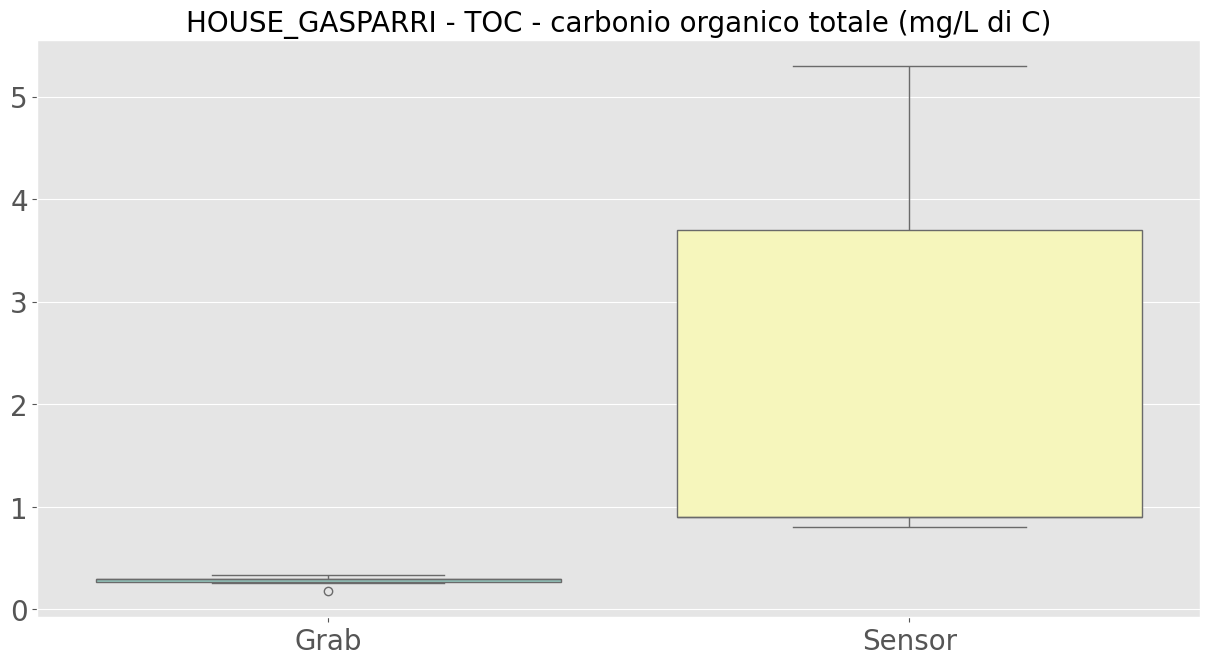

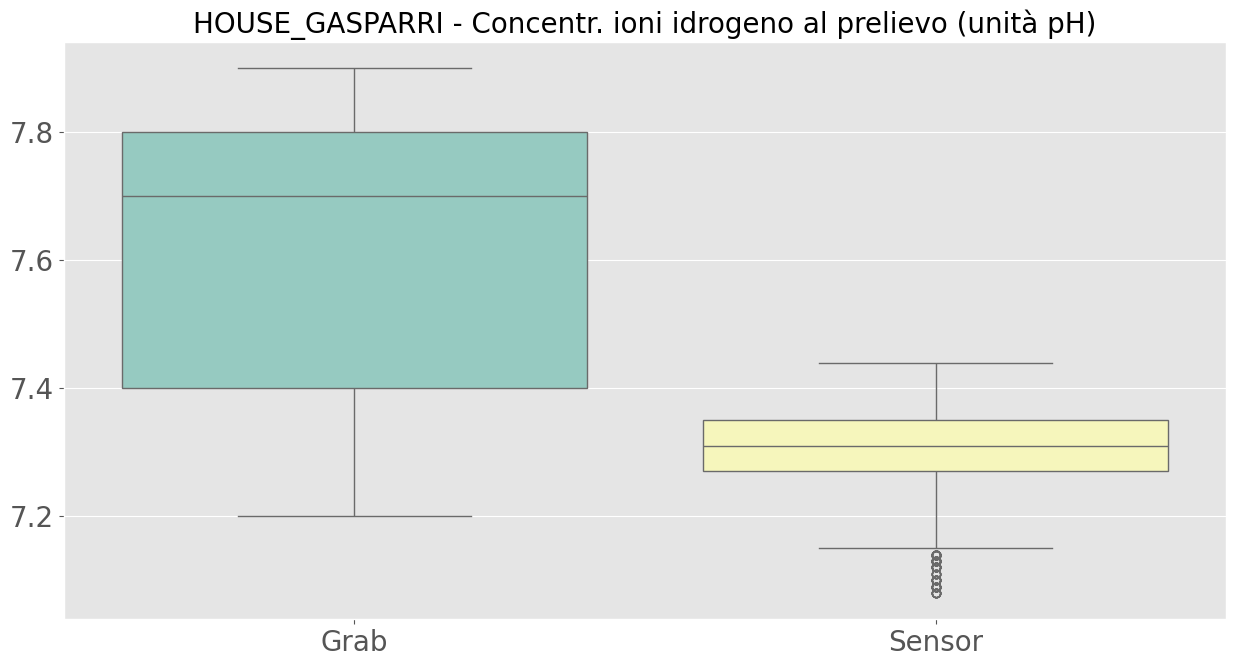

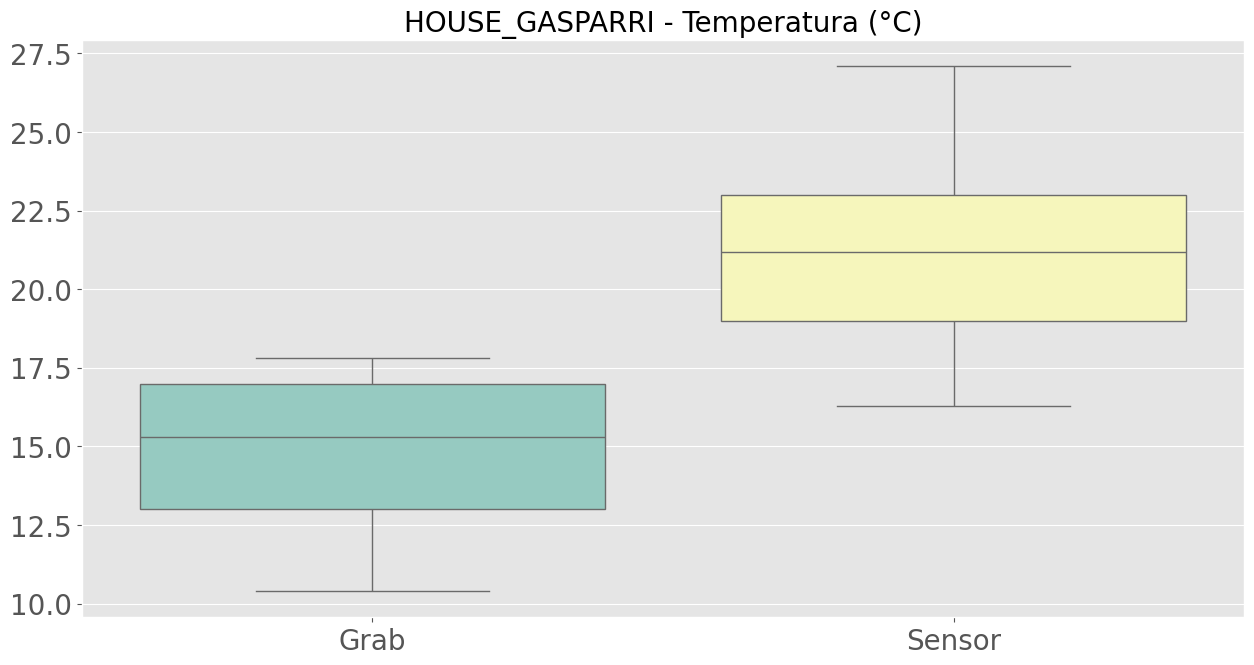

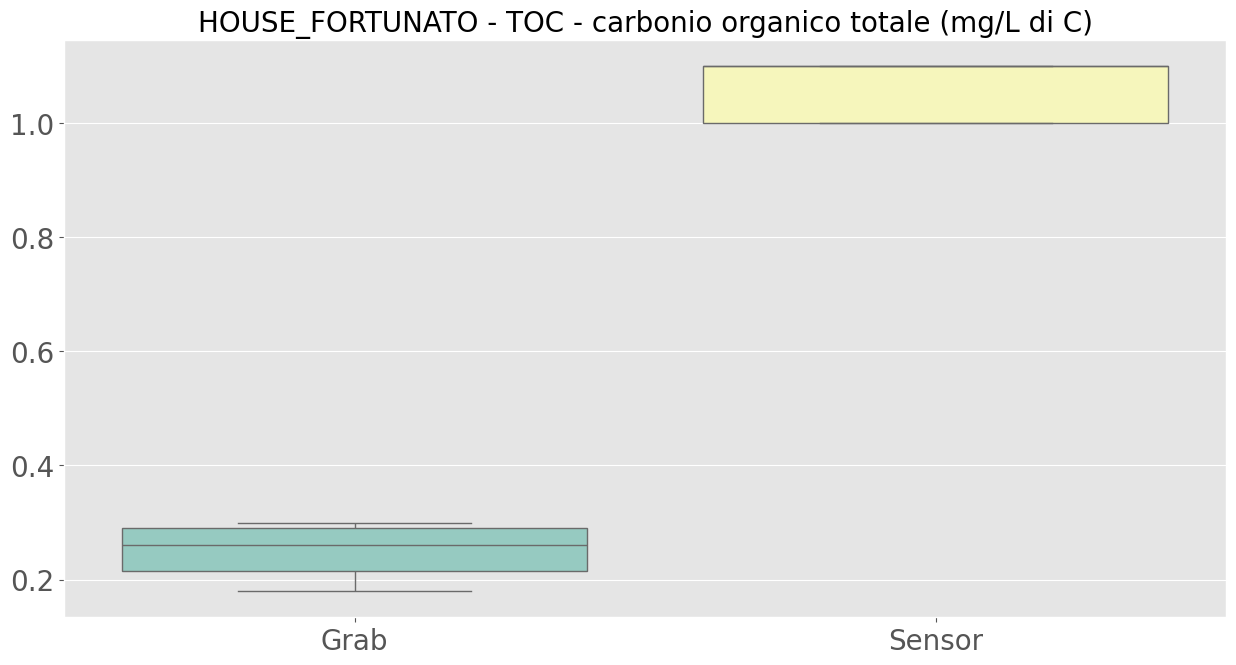

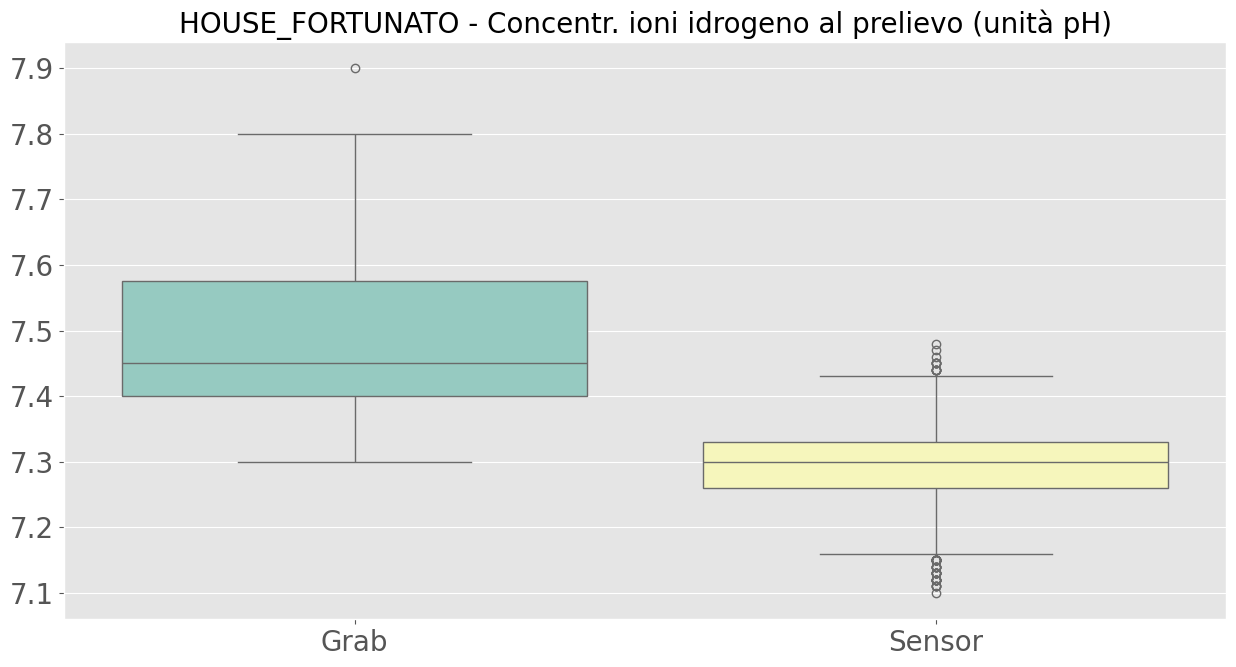

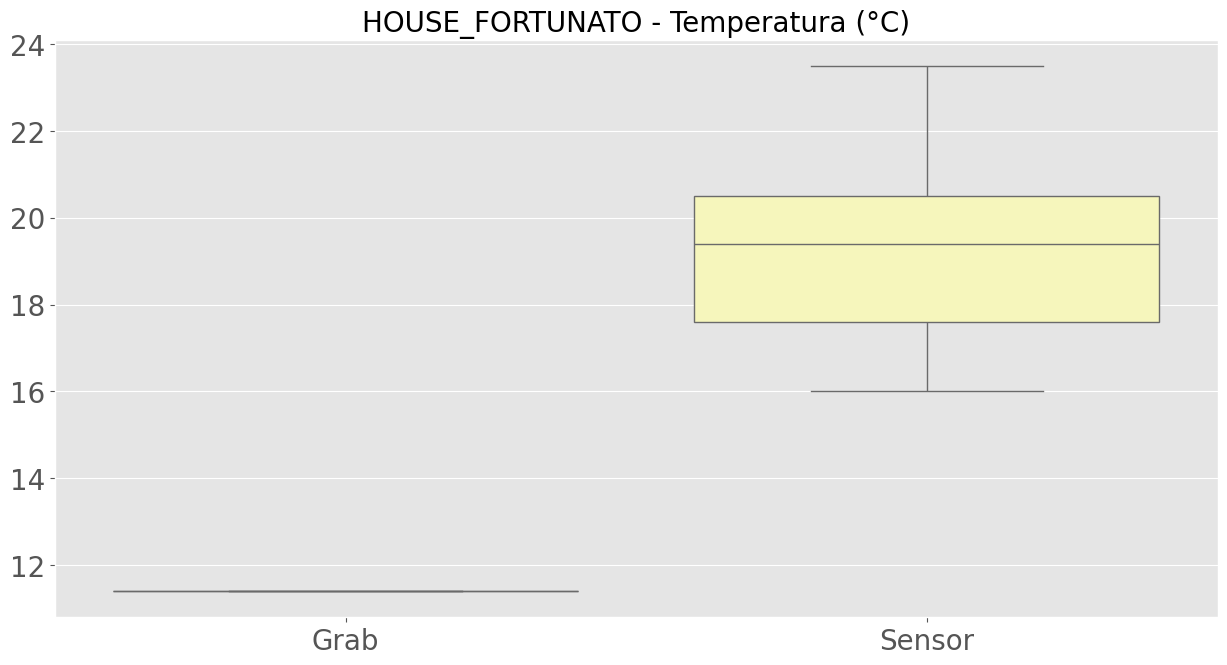

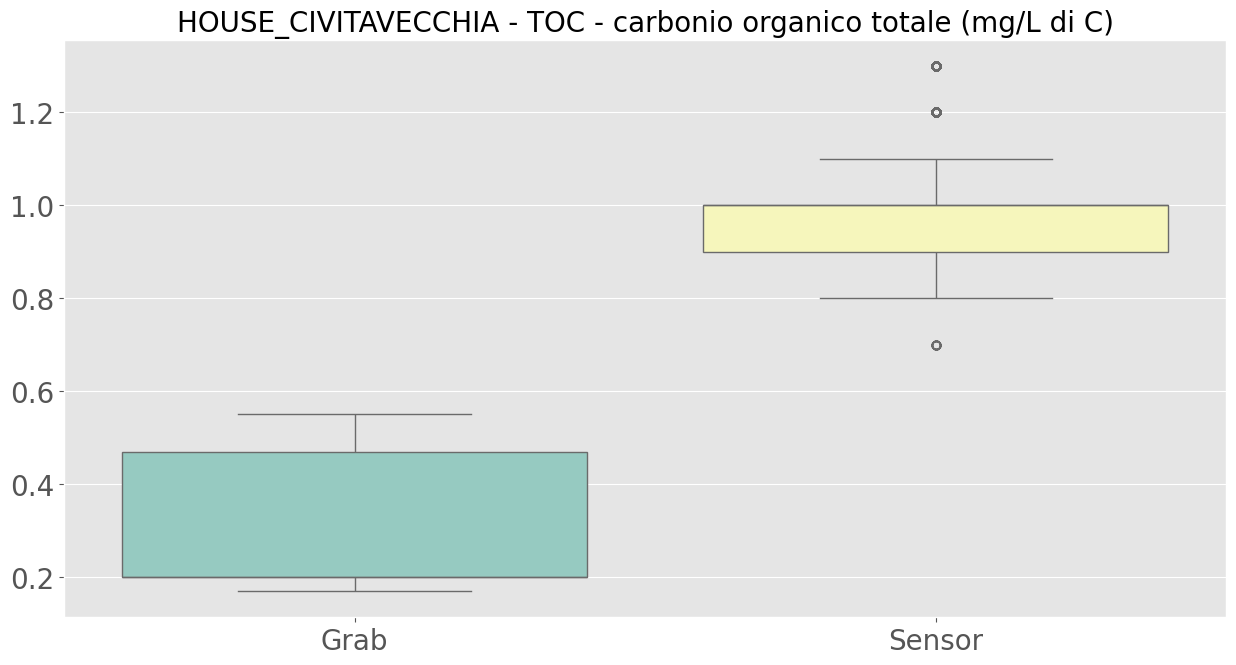

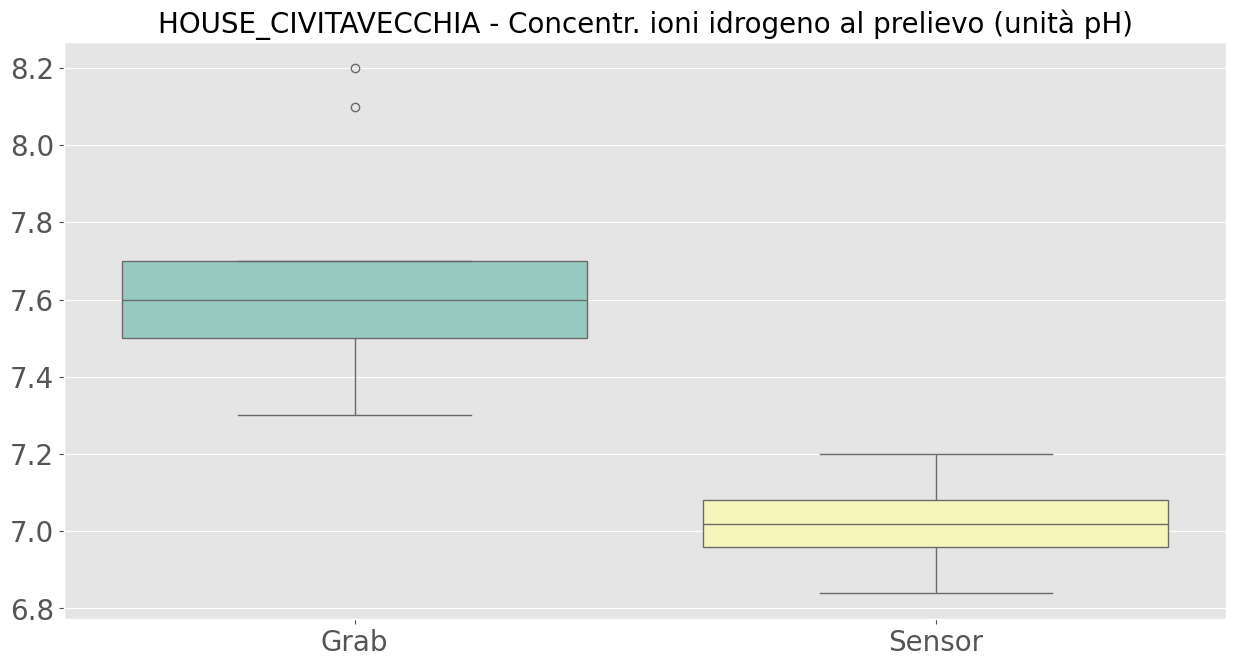

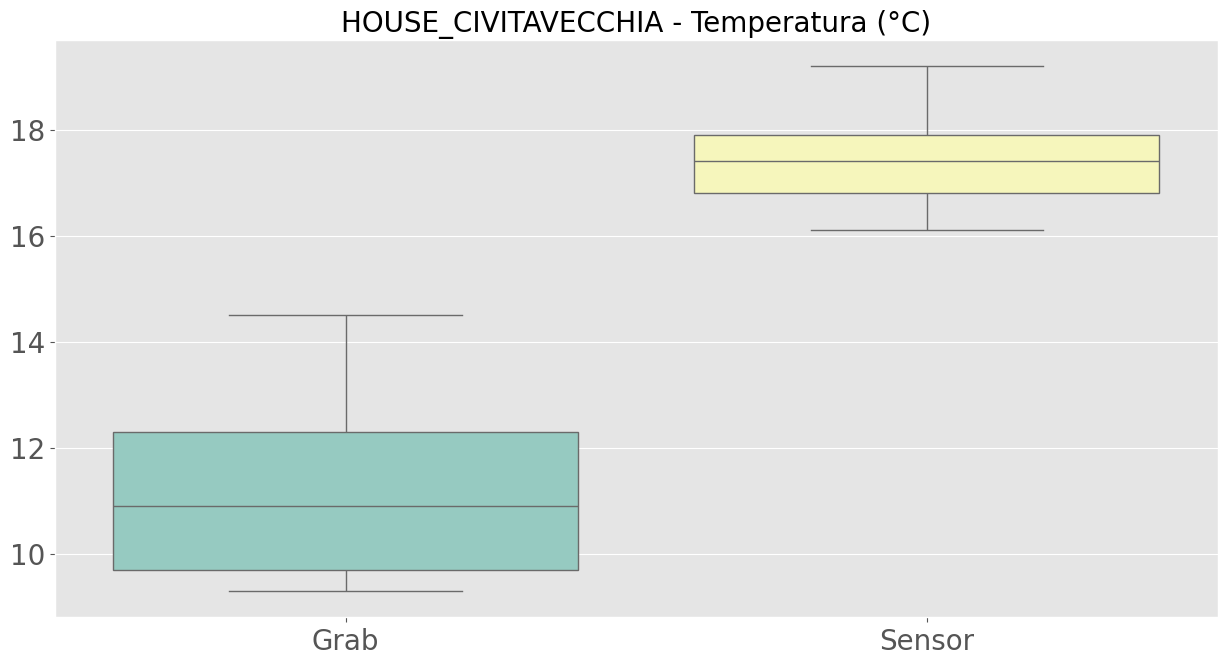

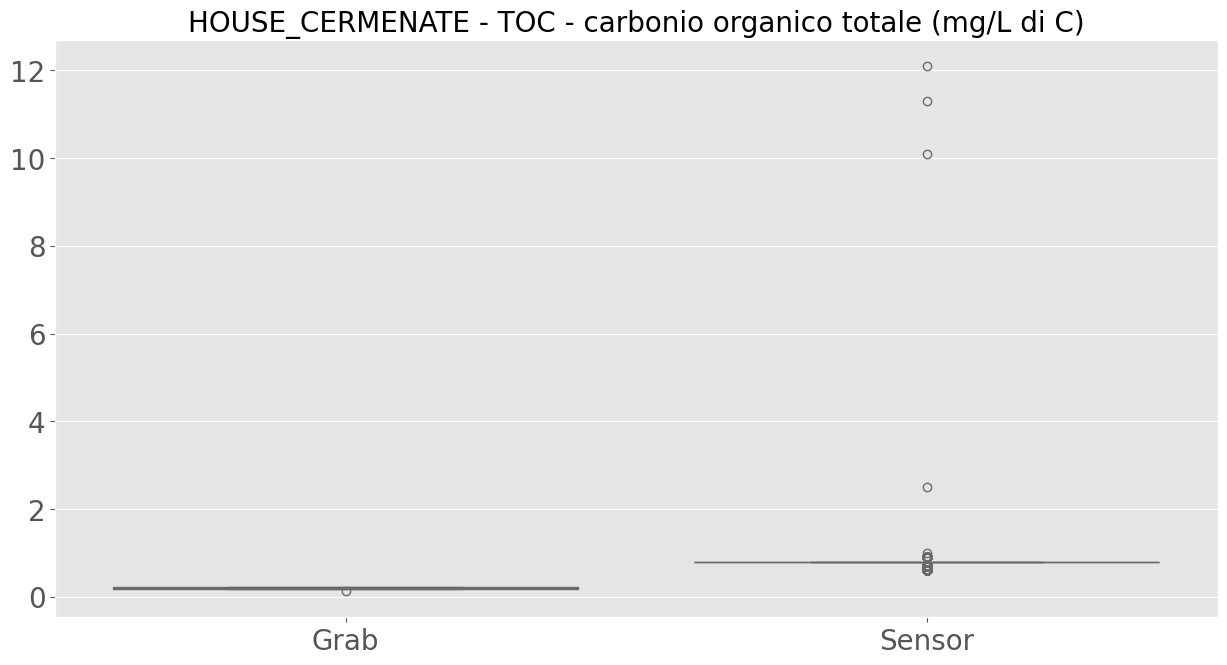

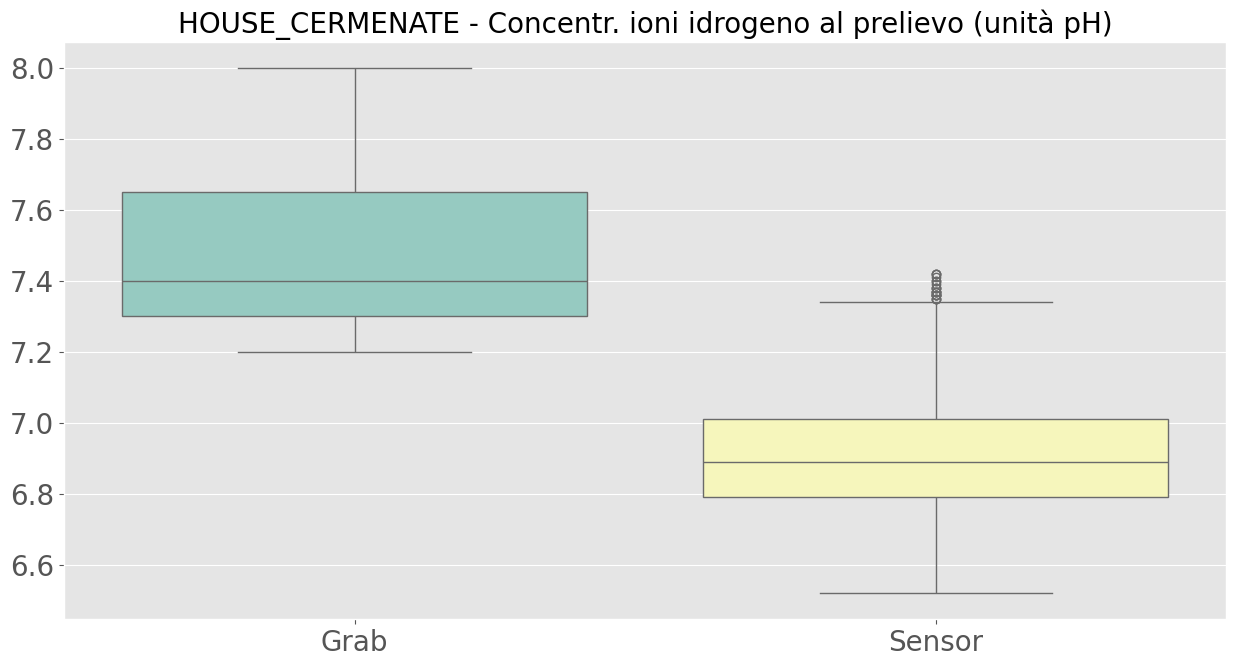

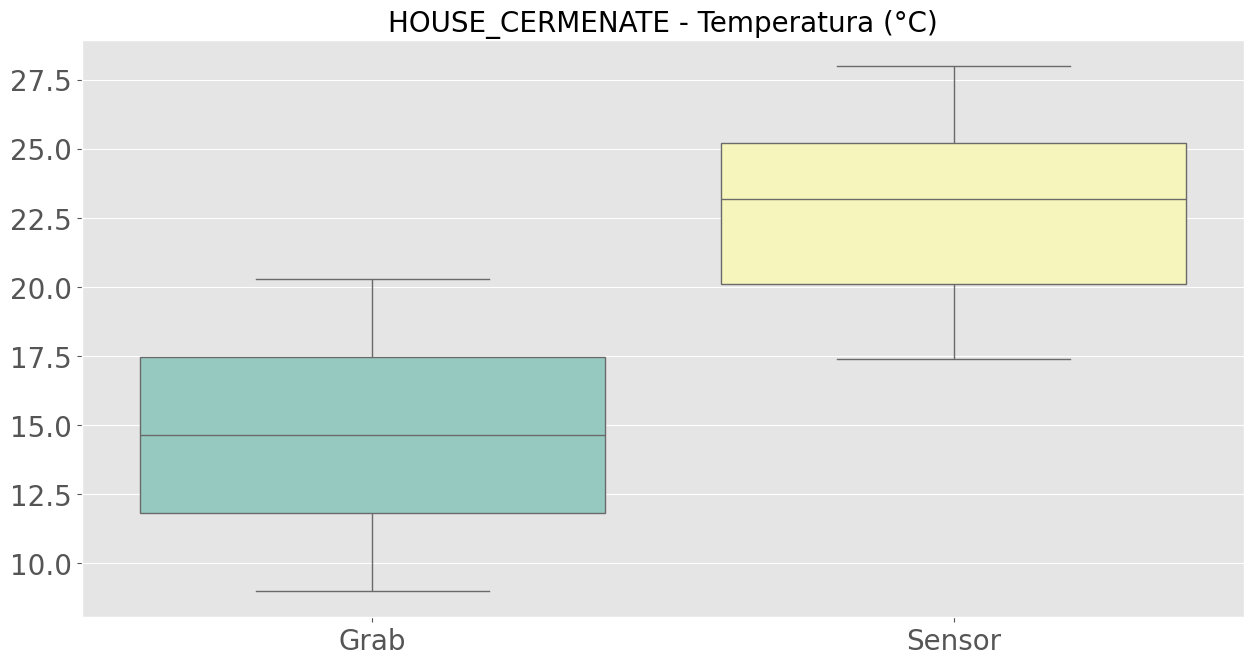

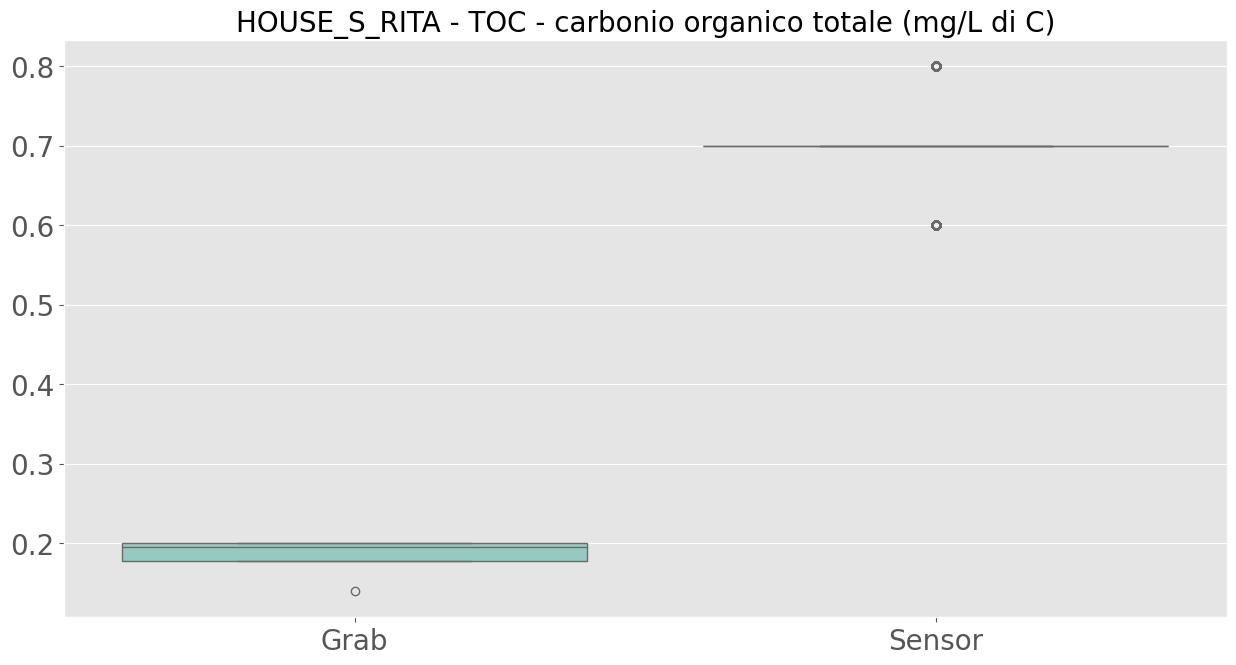

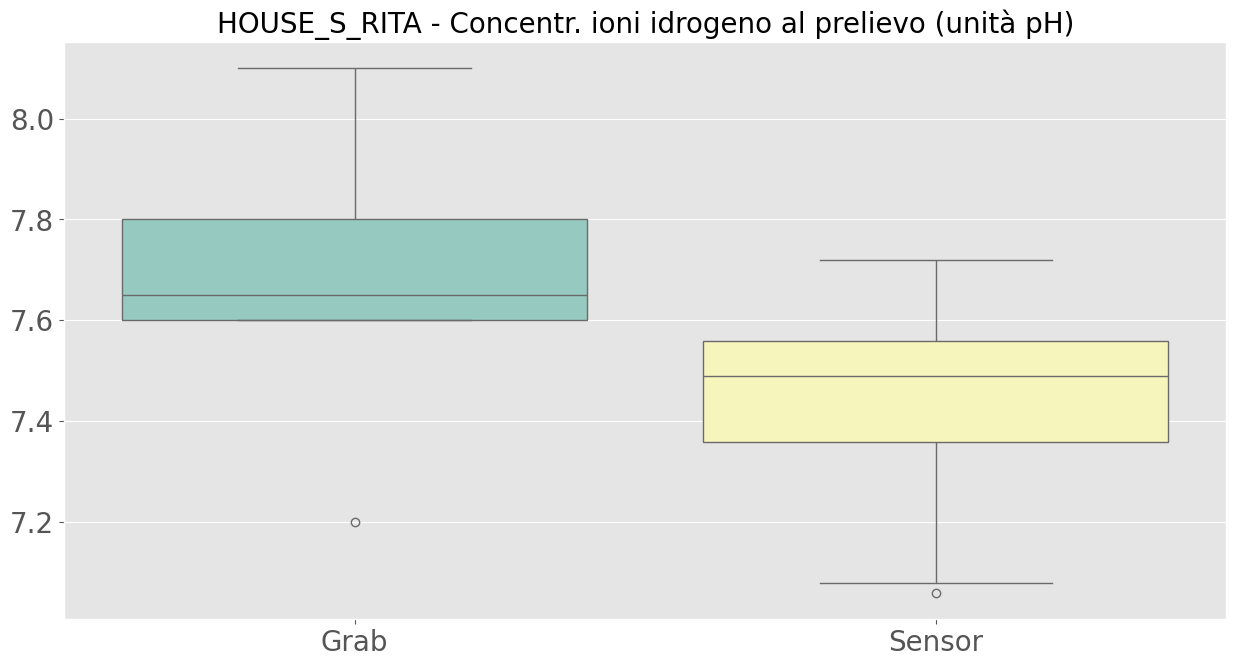

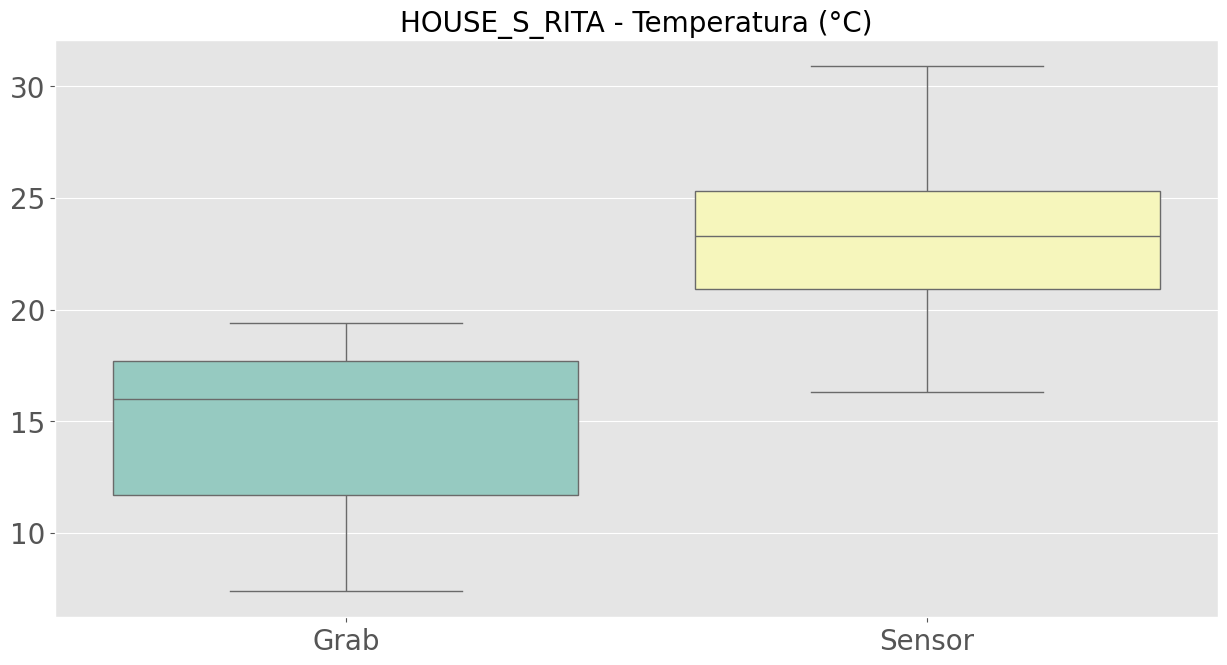

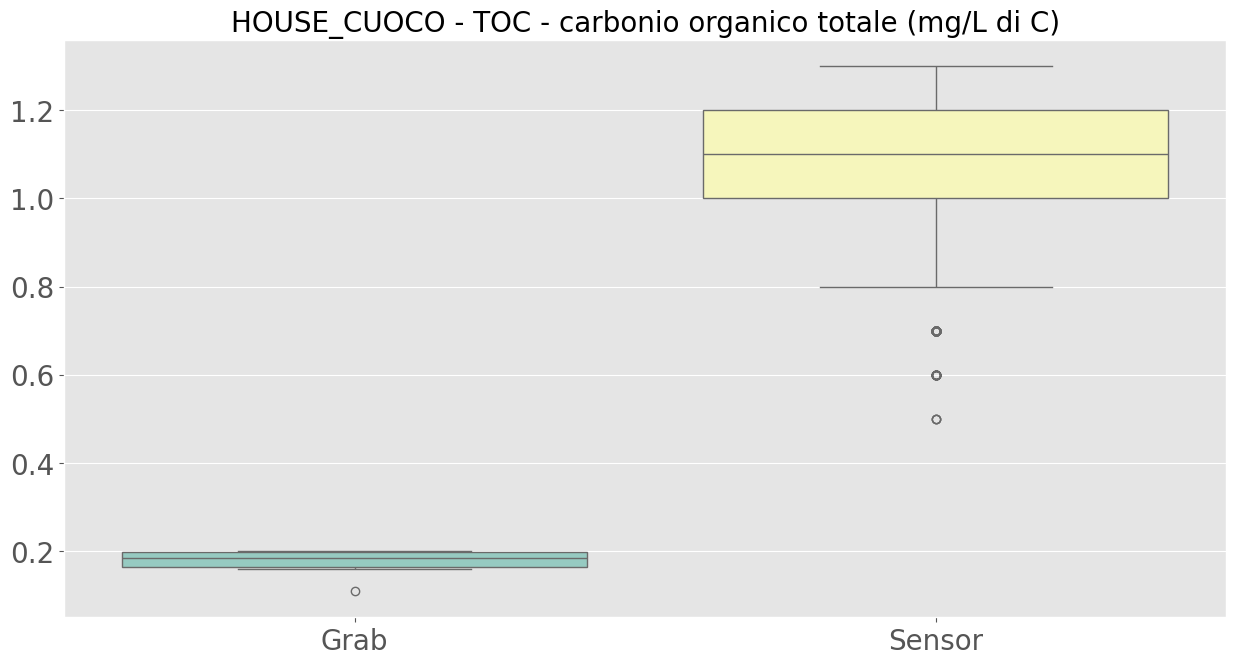

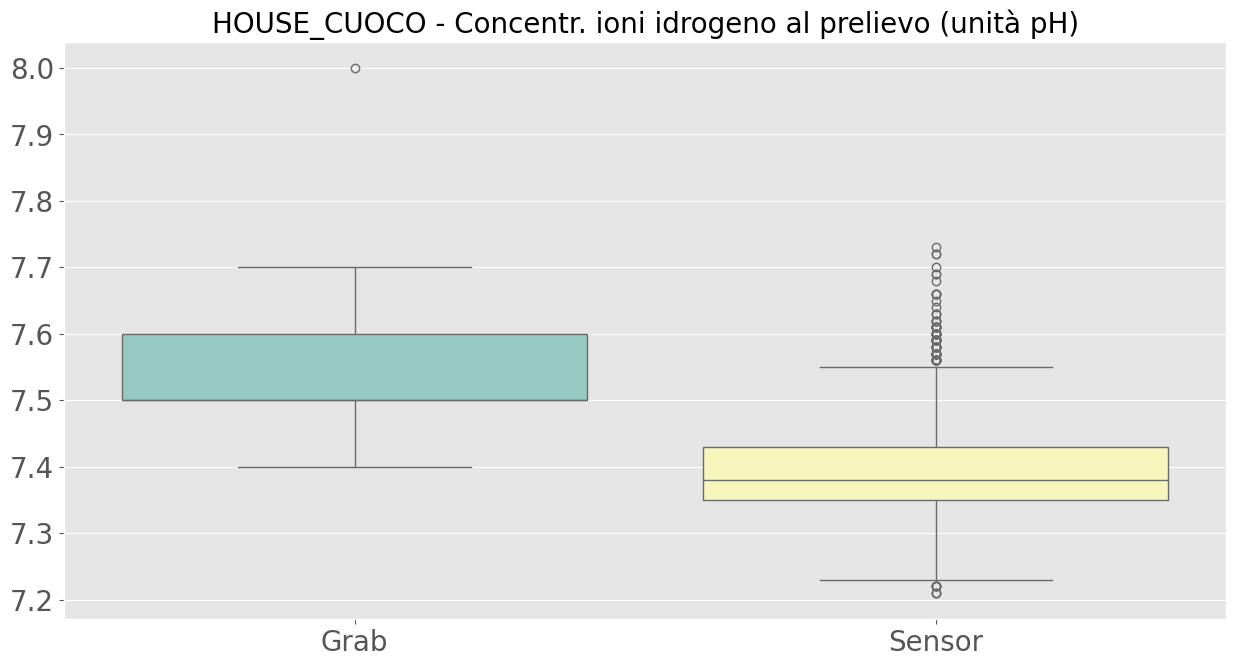

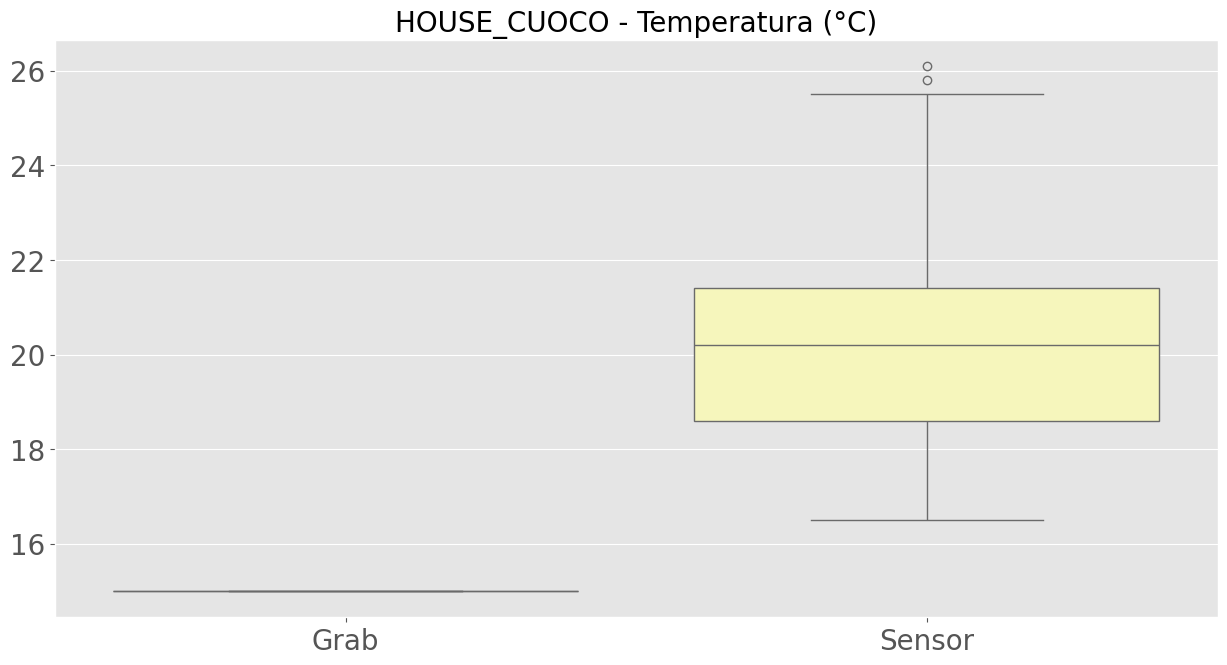

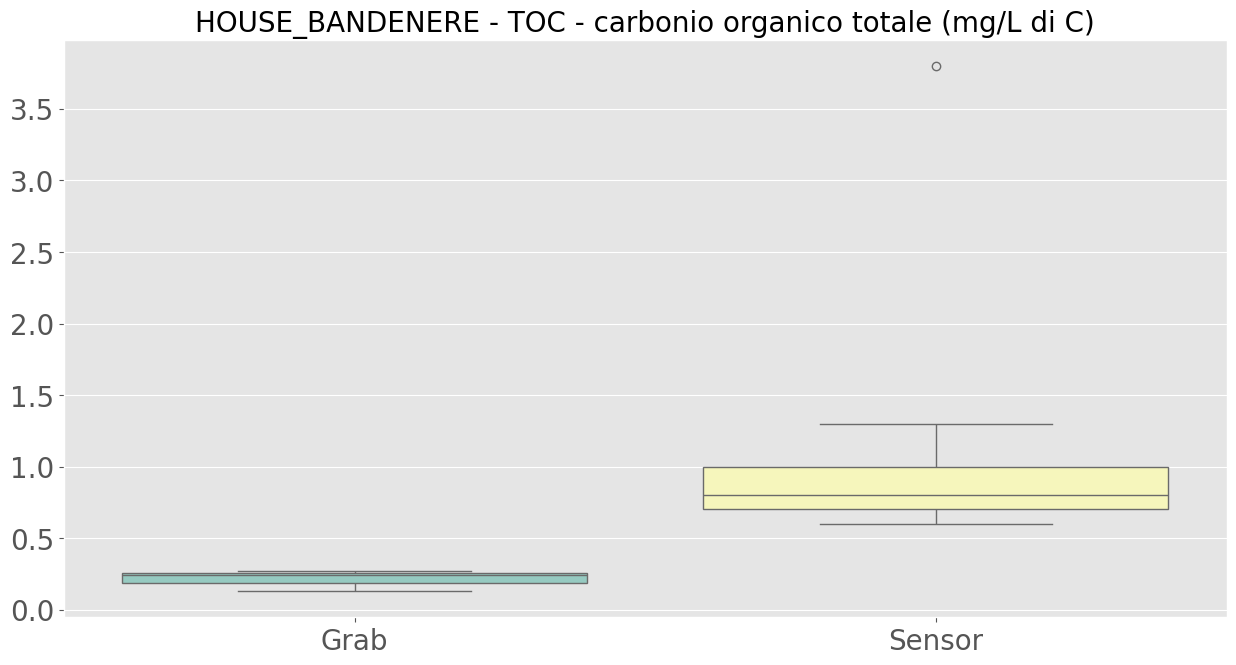

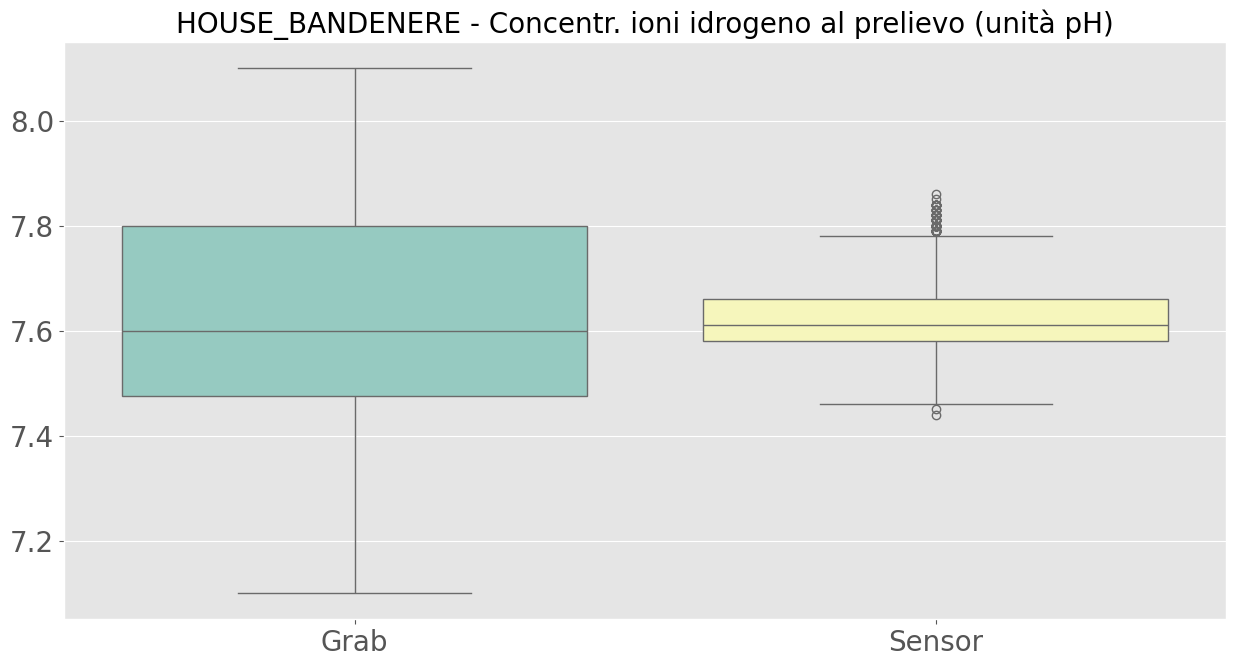

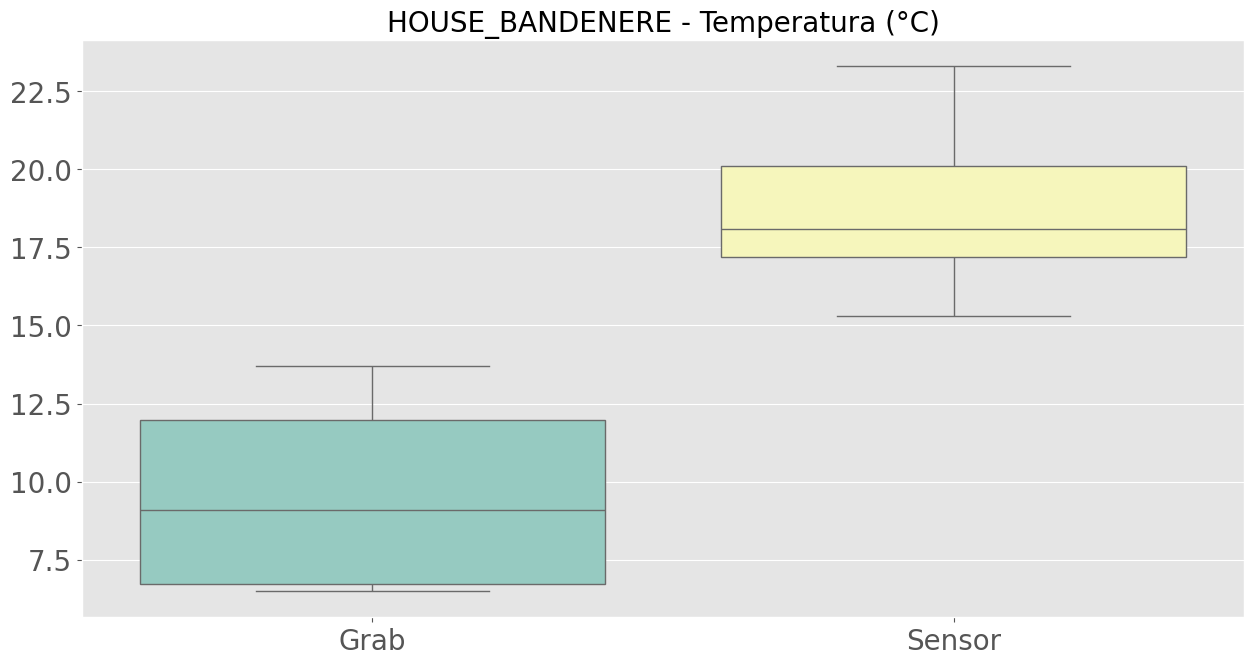

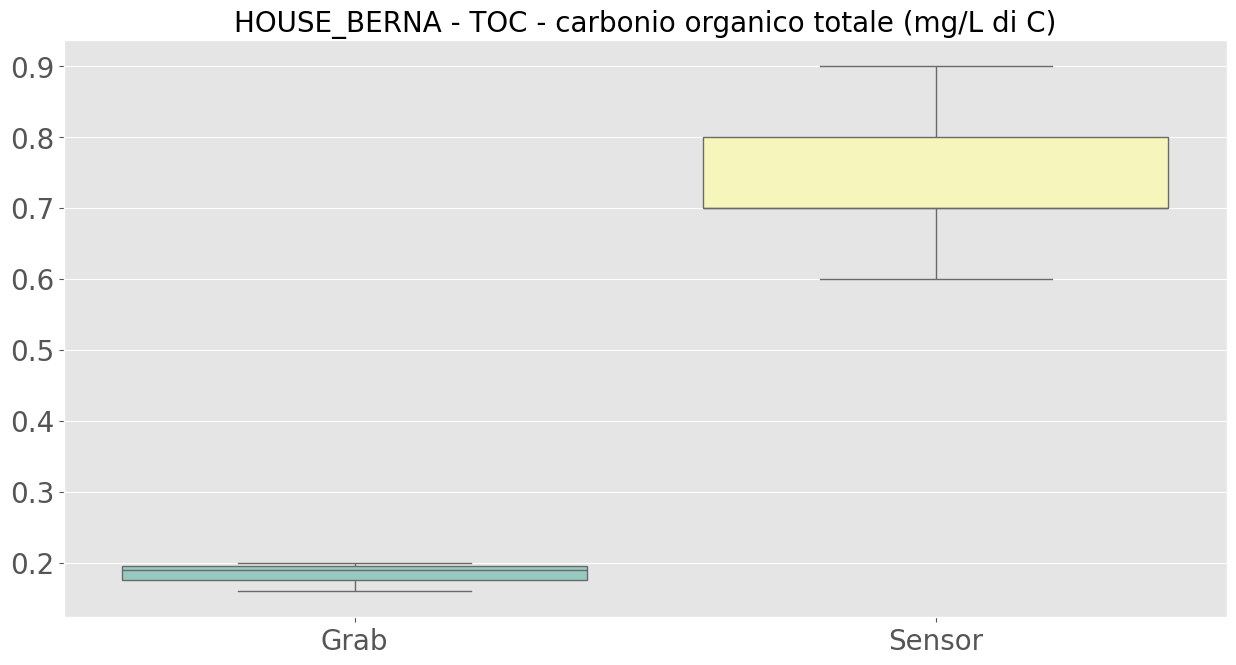

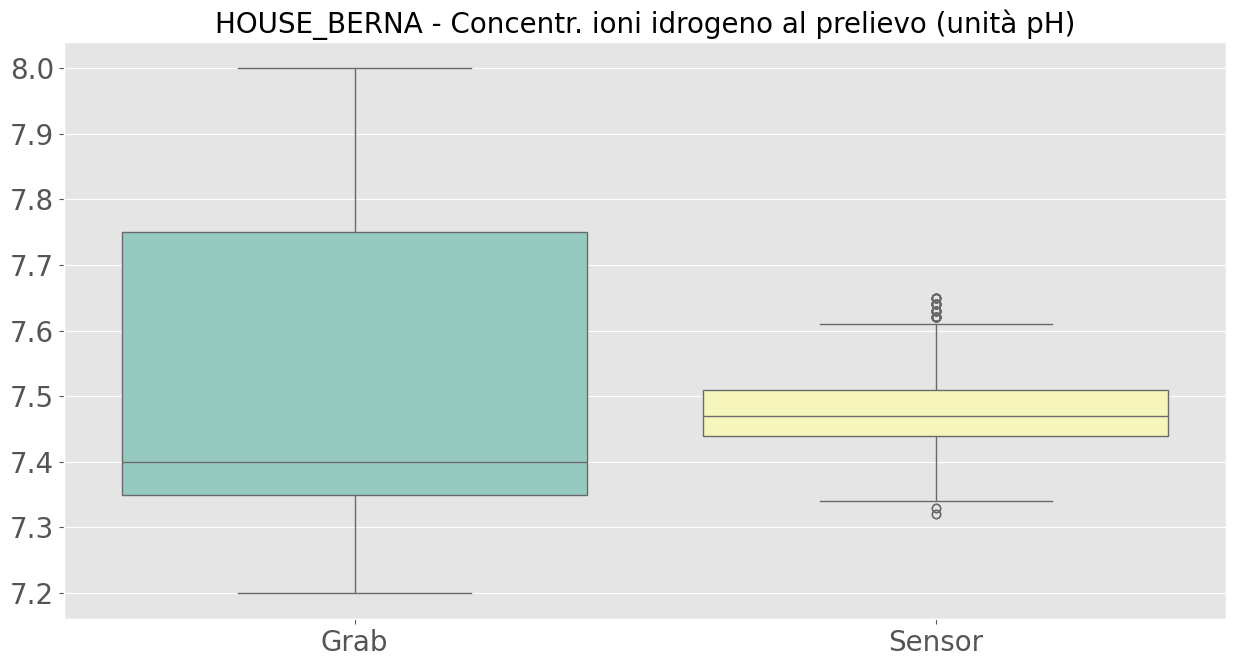

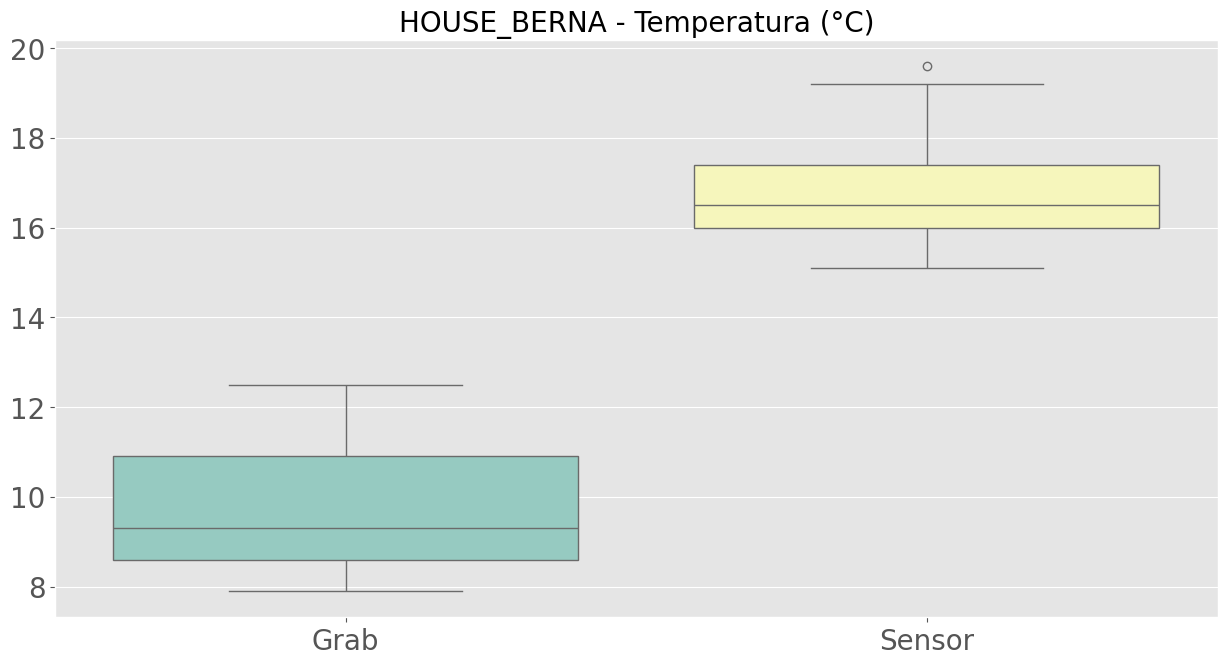

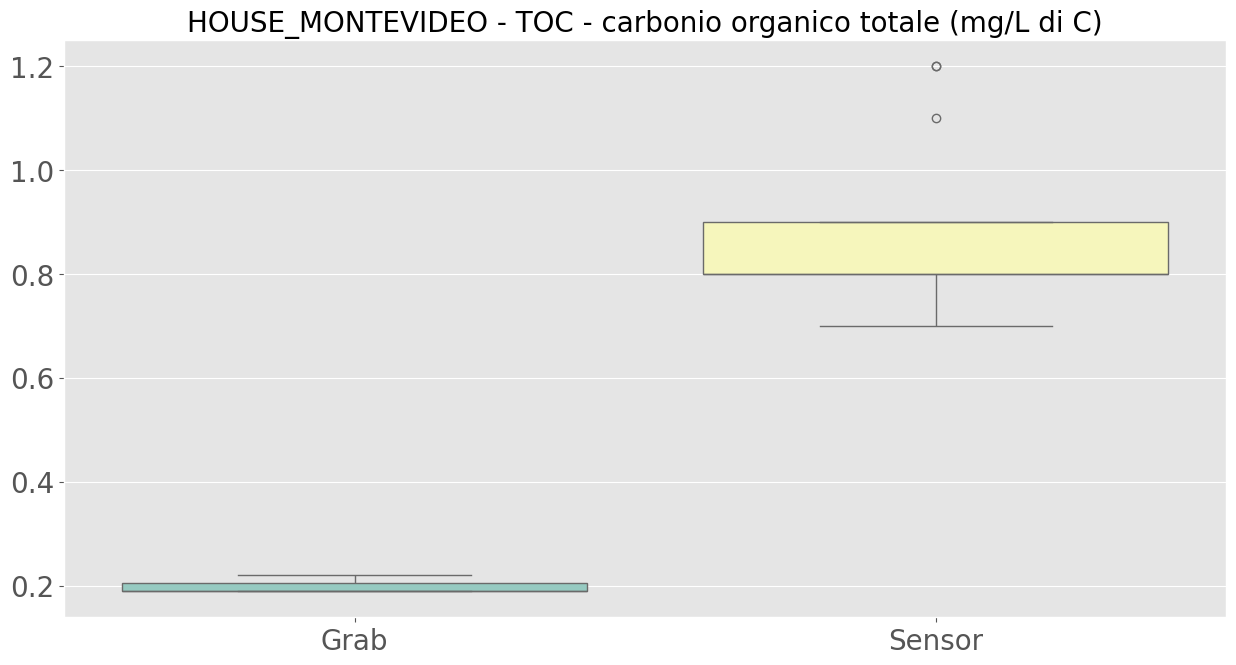

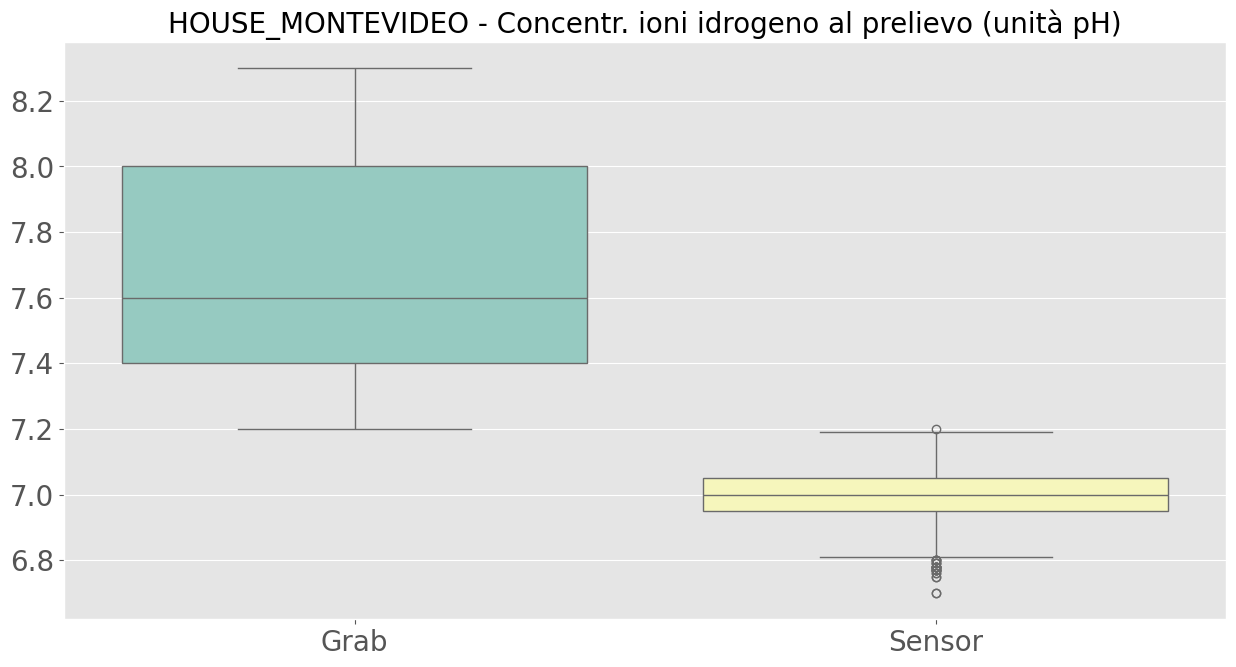

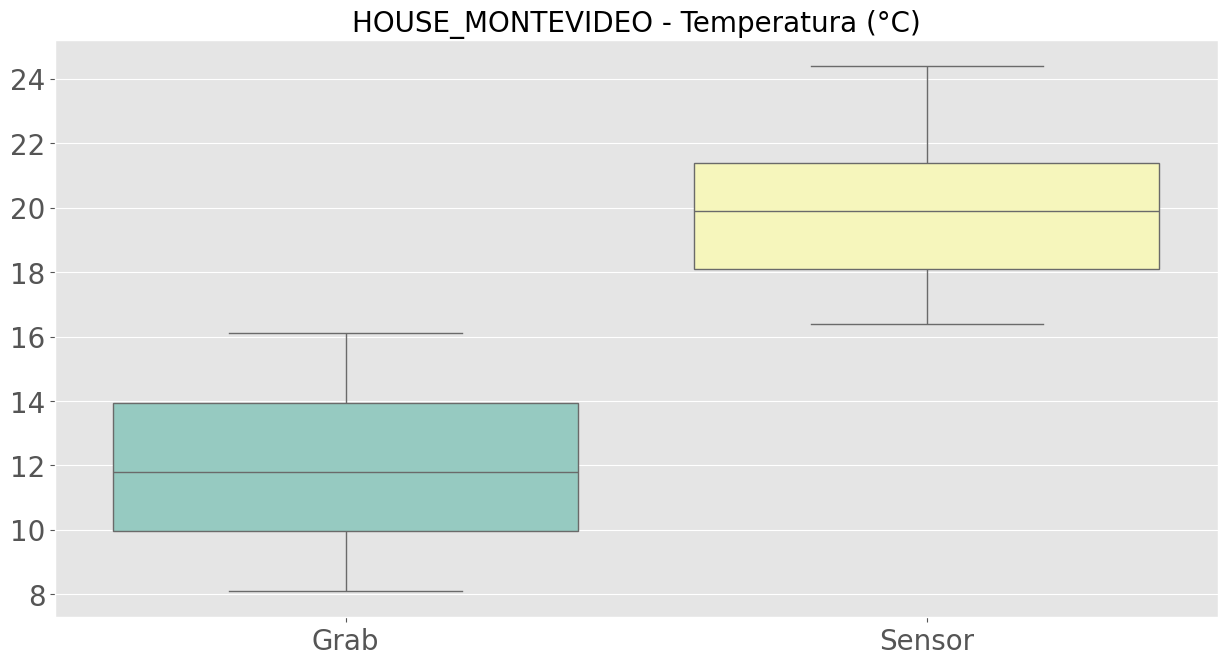

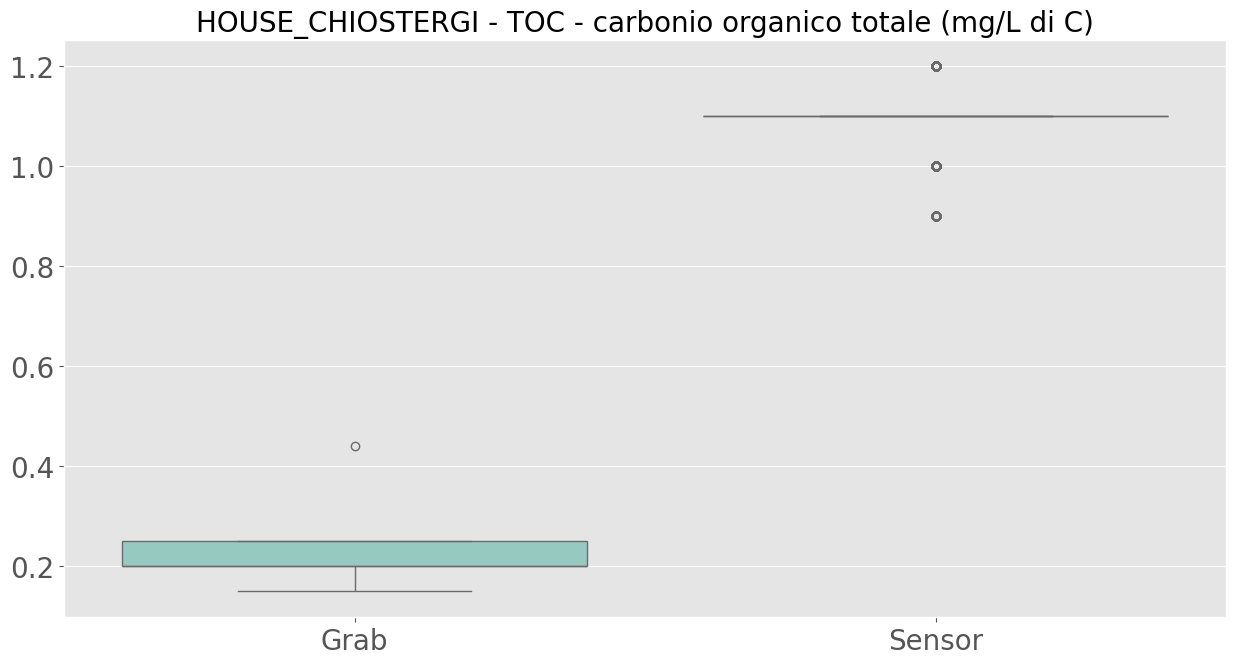

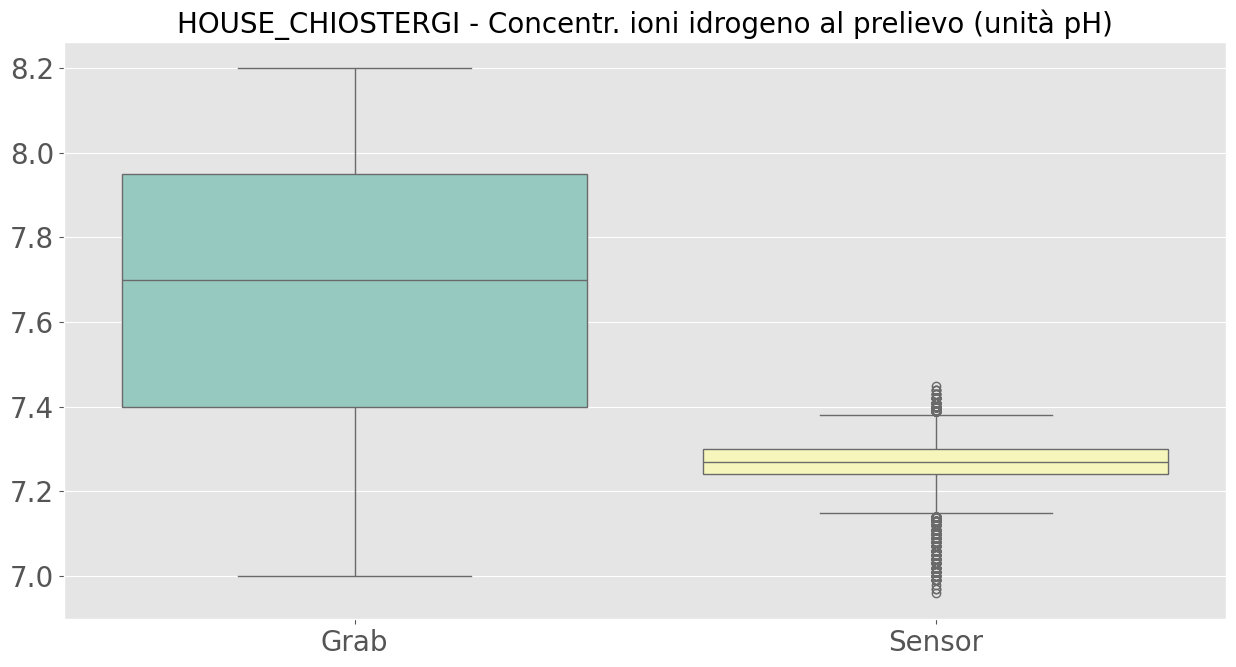

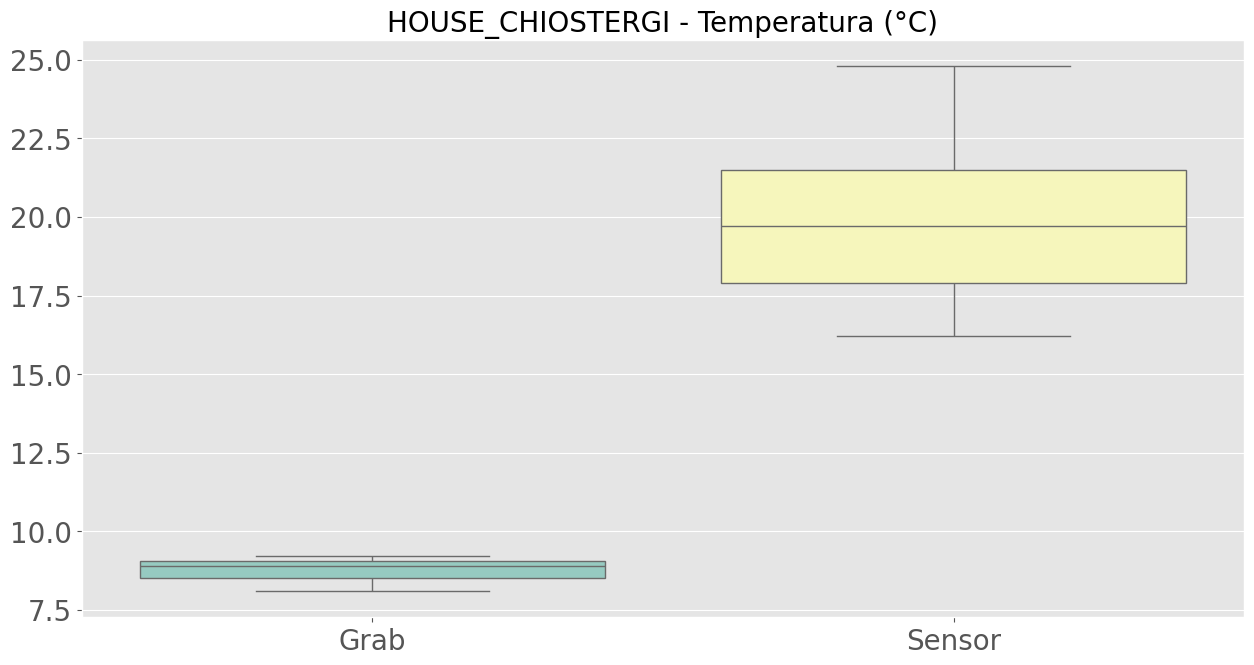

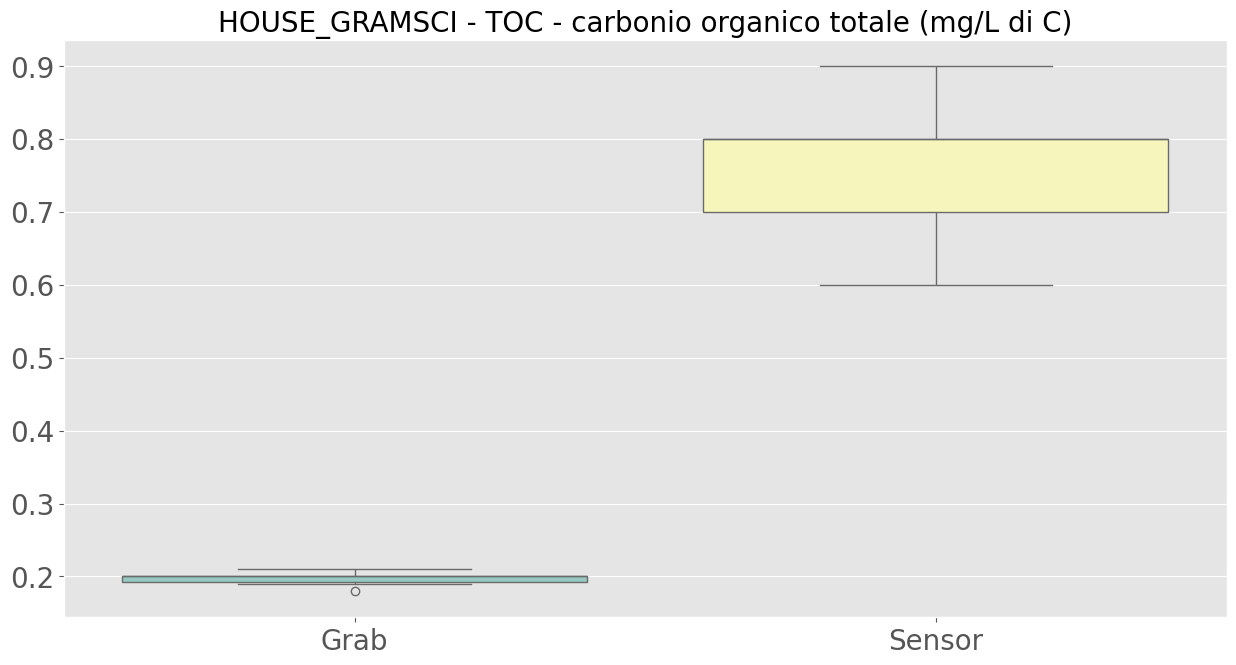

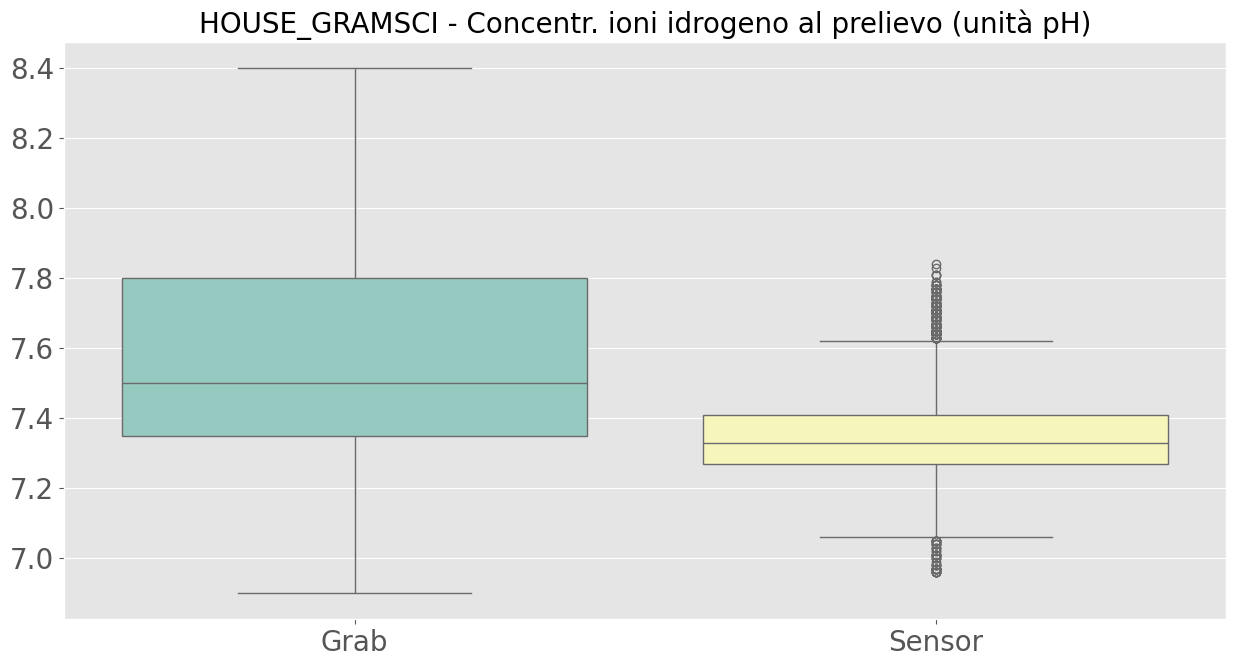

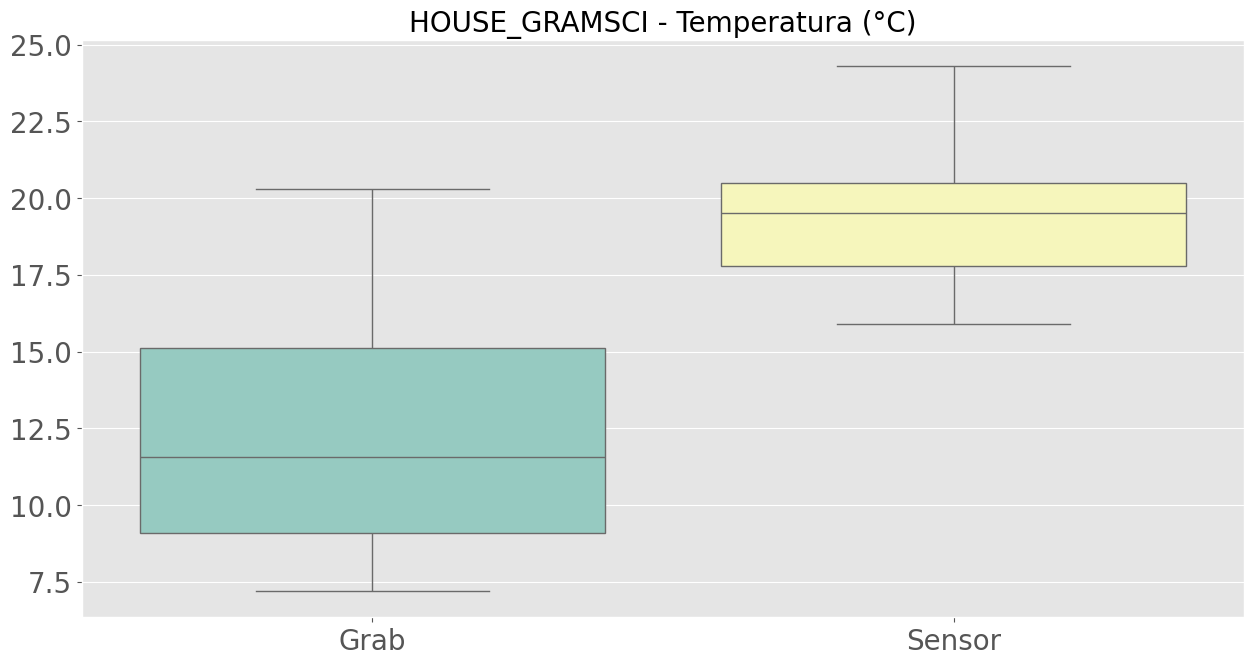

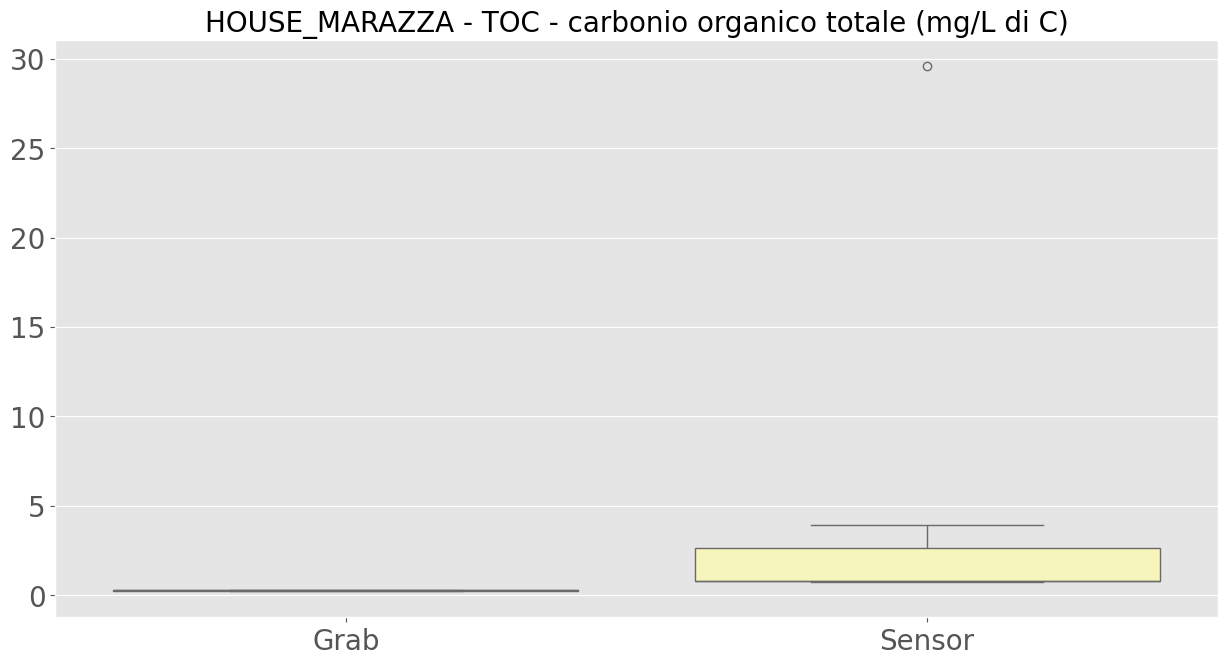

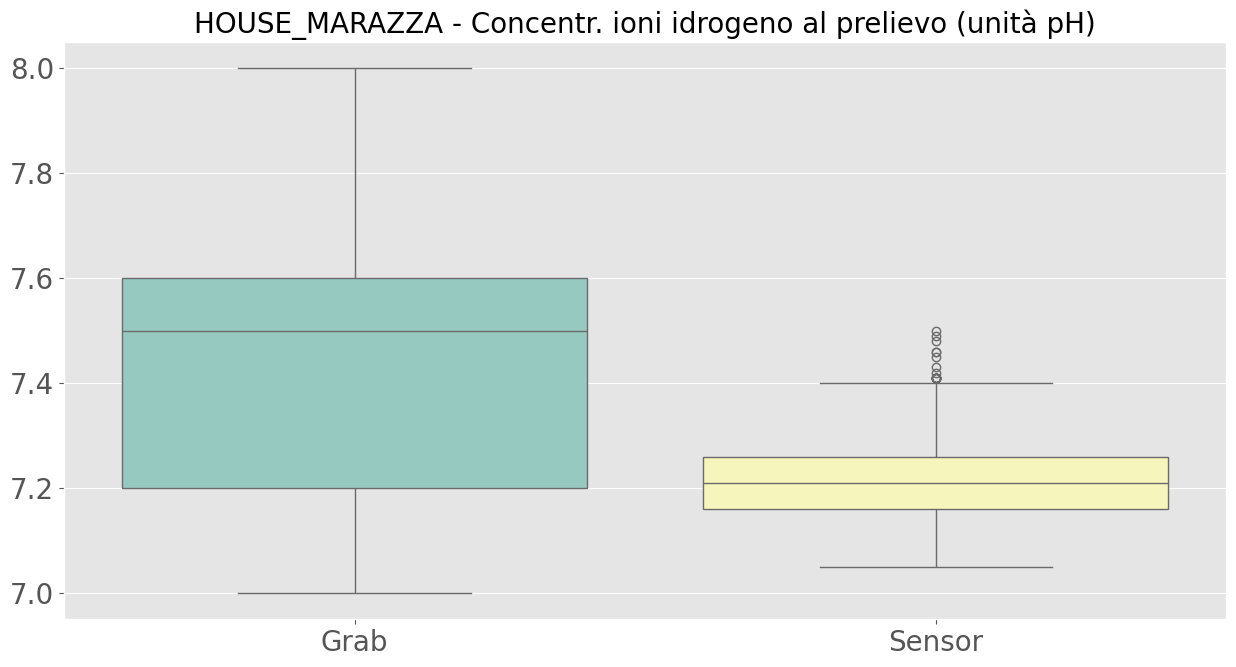

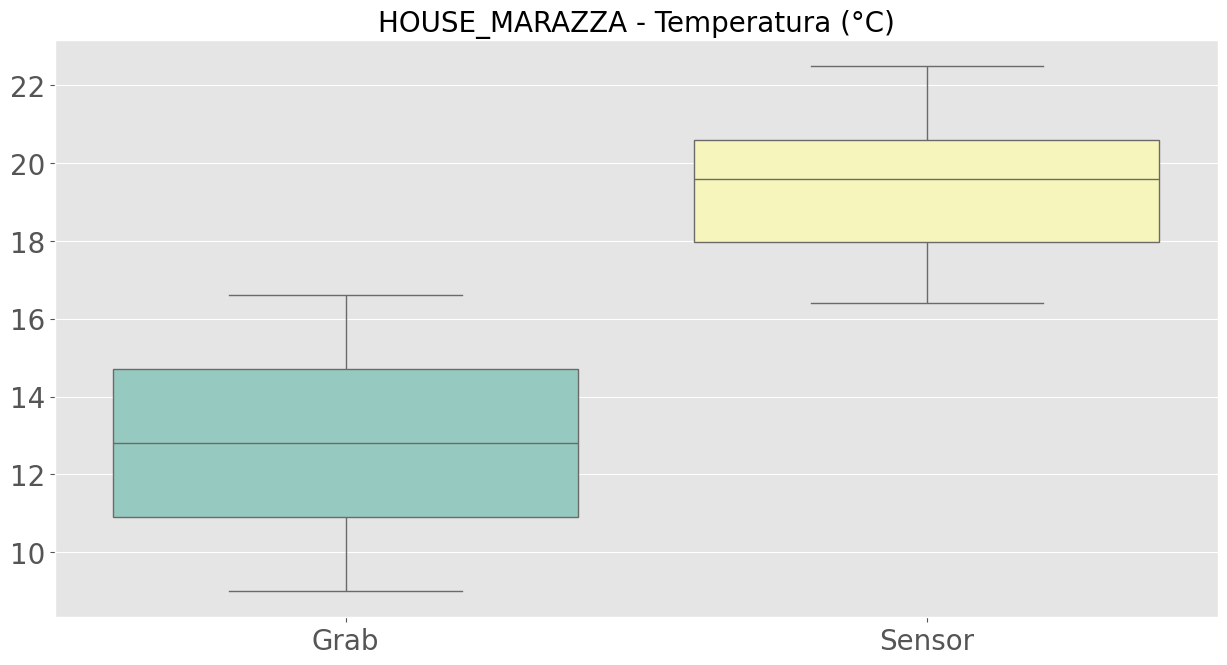

In [228]:
from matplotlib.lines import Line2D

plt.rcParams.update({'font.size': 20})

codes = grab_df["Codice punto di prelievo"].unique()

for code in codes:
    code_grab_df = grab_df[grab_df["Codice punto di prelievo"] == code]
    code_sensor_df = sensor_df[sensor_df["Codice punto di prelievo"] == code]

    for column in common_features:
        plt.figure(figsize=(15, 7.5))

        # boxplot of grab and sensor data
        grab = deepcopy(code_grab_df[column])
        sensor = deepcopy(code_sensor_df[column])
        
        # rename columns
        grab.name = "Grab"
        sensor.name = "Sensor"
        
        sns.boxplot(
            data=[grab, sensor],
            palette="Set3",
        )
        
        plt.title(code + ' - ' + column, fontsize=20)

        directory = os.path.join(
            boxplot_folder, "Grab vs Sensor by House", code
        )
        if not os.path.exists(directory):
            os.makedirs(directory)
        filename = sanitize_filename(f"{column}.png")
        plt.savefig(os.path.join(directory, filename), dpi=300)
        # plt.show()

# Store Metadata

In [ ]:
# show a table for each index summarizing the time_range_df by showing the number of samples, the start time and the end time for each feature in each house
for code in raw_sensor_data_df["Codice Punto di Prelievo"].unique():
    with pd.ExcelWriter(
        os.path.join(metadata_folder, f"{code}.xlsx")
    ) as writer:
        df = pd.DataFrame()
        for column in list(column_mapping.keys())[1:-1]:
            row = time_range_df.loc[code, column]
            if isinstance(row, dict):
                temp_df = pd.DataFrame(
                    index=list(row.keys()),
                    data=list(row.values()),
                    columns=[column],
                )
                df = pd.concat([df, temp_df], axis=1)
                # df.to_excel(writer, sheet_name=sanitize_filename(column))
            else:
                continue
        min_time = pd.to_datetime(
            raw_sensor_data_df[
                raw_sensor_data_df["Codice Punto di Prelievo"] == code
            ]["Measurement interval=900[sec] (Export-Aggregation disabled)"],
            format="%d/%m/%Y %H:%M",
            dayfirst=True,
        ).min()
        max_time = pd.to_datetime(
            raw_sensor_data_df[
                raw_sensor_data_df["Codice Punto di Prelievo"] == code
            ]["Measurement interval=900[sec] (Export-Aggregation disabled)"],
            format="%d/%m/%Y %H:%M",
            dayfirst=True,
        ).max()
        sens_df = pd.DataFrame(
            index=["start_time", "end_time"],
            data=[min_time, max_time],
            columns=["sensor"],
        )
        df = pd.concat([df, sens_df], axis=1)
        df.to_excel(writer, sheet_name=code)

# Common time interval between sensor and grab

In [ ]:
for code in codes:
    code_grab_df = grab_df[grab_df["Codice punto di prelievo"] == code]
    code_sensor_df = sensor_df[sensor_df["Codice punto di prelievo"] == code]

    print(f"==== {code} ====")
    print(
        "Sensor: "
        + str(code_sensor_df["Data di prelievo"].min())
        + " - "
        + str(code_sensor_df["Data di prelievo"].max())
    )
    print(
        "Grab: "
        + str(code_grab_df["Data di prelievo"].min())
        + " - "
        + str(code_grab_df["Data di prelievo"].max())
    )
    print()

    if code == "HOUSE_CERMENATE":
        pass

    # get samples that are in the common time range
    grab_time_range_df = code_grab_df[
        (
            code_grab_df["Data di prelievo"]
            >= code_sensor_df["Data di prelievo"].min()
        )
        & (
            code_grab_df["Data di prelievo"]
            <= code_sensor_df["Data di prelievo"].max()
        )
    ]

    sensor_time_range_df = code_sensor_df[
        (
            code_sensor_df["Data di prelievo"]
            >= code_grab_df["Data di prelievo"].min()
        )
        & (
            code_sensor_df["Data di prelievo"]
            <= code_grab_df["Data di prelievo"].max()
        )
    ]

    # plot the samples in the common time range for each feature with different colors
    for column in common_features:
        plt.figure(figsize=(40, 10))

        sns.lineplot(
            data=sensor_time_range_df,
            x="Data di prelievo",
            y=column,
            color="red",
            errorbar=None,
        )

        sns.lineplot(
            data=grab_time_range_df,
            x="Data di prelievo",
            y=column,
            color="blue",
            errorbar=None,
        )

        sns.scatterplot(
            data=grab_time_range_df,
            x="Data di prelievo",
            y=column,
            color="blue",
        )

        plt.title(code, fontsize=20)
        plt.xlabel("Time", fontsize=20)
        plt.ylabel(column, fontsize=20)

        custom_lines = [
            Line2D([0], [0], color="red", lw=4),
            Line2D([0], [0], color="blue", lw=4),
        ]
        plt.legend(custom_lines, ["Sensor", "Grab"])

        directory = os.path.join(timeseries_folder, "Common Time Range", code)
        if not os.path.exists(directory):
            os.makedirs(directory)
        filename = sanitize_filename(f"{column}.png")
        plt.savefig(os.path.join(directory, filename), dpi=300)
        # plt.show()